# Libraries

In [13]:
import pandas as pd
import numpy as np
import random as rn
import math
import os

import itertools
# import pyathena
# from pyathena.pandas.cursor import PandasCursor

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mp_colors
from matplotlib.dates import DateFormatter
import seaborn as sns

import networkx as nx

from datetime import date
import datetime

import warnings
warnings.filterwarnings("ignore")

##### COLORS

In [18]:
## Colors
color_blue = '#0075b0'
color_gray = '#9ba6a5'
color_total_traffic = '#0075b0'
color_blue_white = '#eaf6f6'
color_intl = '#f1ce63'
color_longhaul = '#8109b7'
color_metro = '#a55233'#'#8cd17d'
color_exp_reg = '#283739'
color_local_cagr = '#379956'
color_global_cagr = '#9ba6a5'
color_holt_winters = '#ffb5b5'
color_sarima = '#cbf078'
color_timeline_devider = '#f64b3c'

## Color pallets
cmap_white_to_blue = mp_colors.LinearSegmentedColormap.from_list("", [color_blue_white, color_total_traffic])

## tx systems
tx_sys_longhaul = '50086CGWP'
tx_sys_international = 'WAWT-424'
tx_sys_metro = 'CGSO-4754'

# 1. THE NETWORK

In [14]:
master_df = pd.read_csv('core_traffic.csv')
master_df

,Unnamed: 0,month,month_chart,device_name,interface_name,dest_from_alias,base_doc_id,bits_in_max,bits_out_max
0,0,2015-05-01,2015-05,rd3ha.ss,Bundle-Ether7,rc3sc.wp,WPSC-1119,7.043480e+09,8.112180e+08
1,1,2015-06-01,2015-06,rc3no.cg,Bundle-Ether12,rd3ht.ok,CGNO-4501,2.651238e+09,6.376355e+09
2,2,2015-06-01,2015-06,rd3ha.ss,Bundle-Ether7,rc3sc.wp,WPSC-1119,8.483581e+09,9.103239e+08
3,3,2015-06-01,2015-06,rd3ht.ok,Bundle-Ether12,rc3no.cg,CGNO-4501,6.384835e+09,2.649271e+09
4,4,2015-07-01,2015-07,rd3ha.ss,Bundle-Ether7,rc3sc.wp,WPSC-1119,8.259827e+09,8.032940e+08
...,...,...,...,...,...,...,...,...,...
6157,6157,2023-06-01,2023-06,rds1he.rd,Bundle-Ether9,rc3no.cg,RDHE-567,5.397425e+07,2.114314e+07
6158,6158,2023-06-01,2023-06,rds2ha.ss,Bundle-Ether1,rds1ha.ss,SSHA-1317,3.867219e+08,4.006397e+06
6159,6159,2023-06-01,2023-06,rds2ha.ss,Bundle-Ether214,rc2ar.ed,SSHA-1324,3.063809e+07,4.464694e+06
6160,6160,2023-06-01,2023-06,rds2he.rd,Bundle-Ether2,rds1he.rd,RDHE-574,7.275752e+07,9.789026e+05


In [15]:
# heatmap
df_agg = master_df[(master_df['bits_in_max'].notnull())].groupby(['month_chart', 'base_doc_id'])['device_name'].count().reset_index()
df_agg.loc[df_agg['device_name']>0, 'device_name'] = 1
df_agg

,month_chart,base_doc_id,device_name
0,2015-05,WPSC-1119,1
1,2015-06,CGNO-4501,1
2,2015-06,WPSC-1119,1
3,2015-07,WPSC-1119,1
4,2015-08,WPSC-1119,1
...,...,...,...
3268,2023-06,WPNR-2001,1
3269,2023-06,WPNR-2009,1
3270,2023-06,WPNR-2268,1
3271,2023-06,WPSC-1119,1


In [16]:
df_pivot = df_agg.pivot(index='month_chart', columns='base_doc_id', values='device_name').reset_index().set_index('month_chart')
df_pivot = df_pivot.fillna(0).reset_index().set_index('month_chart')
df_pivot

base_doc_id,50086CGWP,50090CGVC,50273CGWP,83322CGVC,CGNO-4298,CGNO-4501,CGNO-4576,CGNO-6389,CGSO-4754,CLSJ-42,...,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WAWT-854,WPNR-2001,WPNR-2009,WPNR-2268,WPSC-1119,WPSC-1733
month_chart,,,,,,,,,,,,,,,,,,,,,
2015-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-09,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2023-03,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2023-04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


[Text(0.5, 1.0, 'Availability of Historical Data\n\n')]

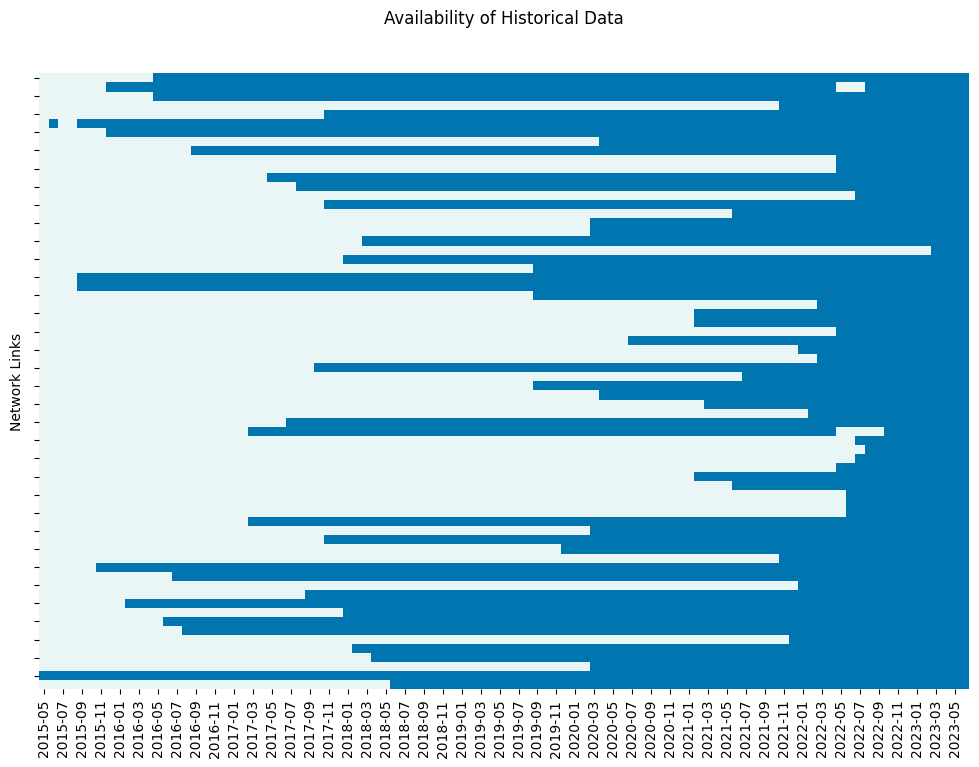

In [19]:
#sns.set(rc={'figure.figsize':(40,20)})
## ------------------------------------------------------------
##                          For the paper
## ------------------------------------------------------------
# fig, axes = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [4, 1]})
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
# cmap = mpcolors.ListedColormap([])
hm = sns.heatmap(df_pivot.T, cmap=cmap_white_to_blue, cbar=False)
hm.set(yticklabels=[]) 
hm.set(xlabel=None)
hm.set(ylabel="Network Links")
hm.set(title="Availability of Historical Data\n\n")

[Text(0.5, 1.0, 'Availability of Historical Data\n\n')]

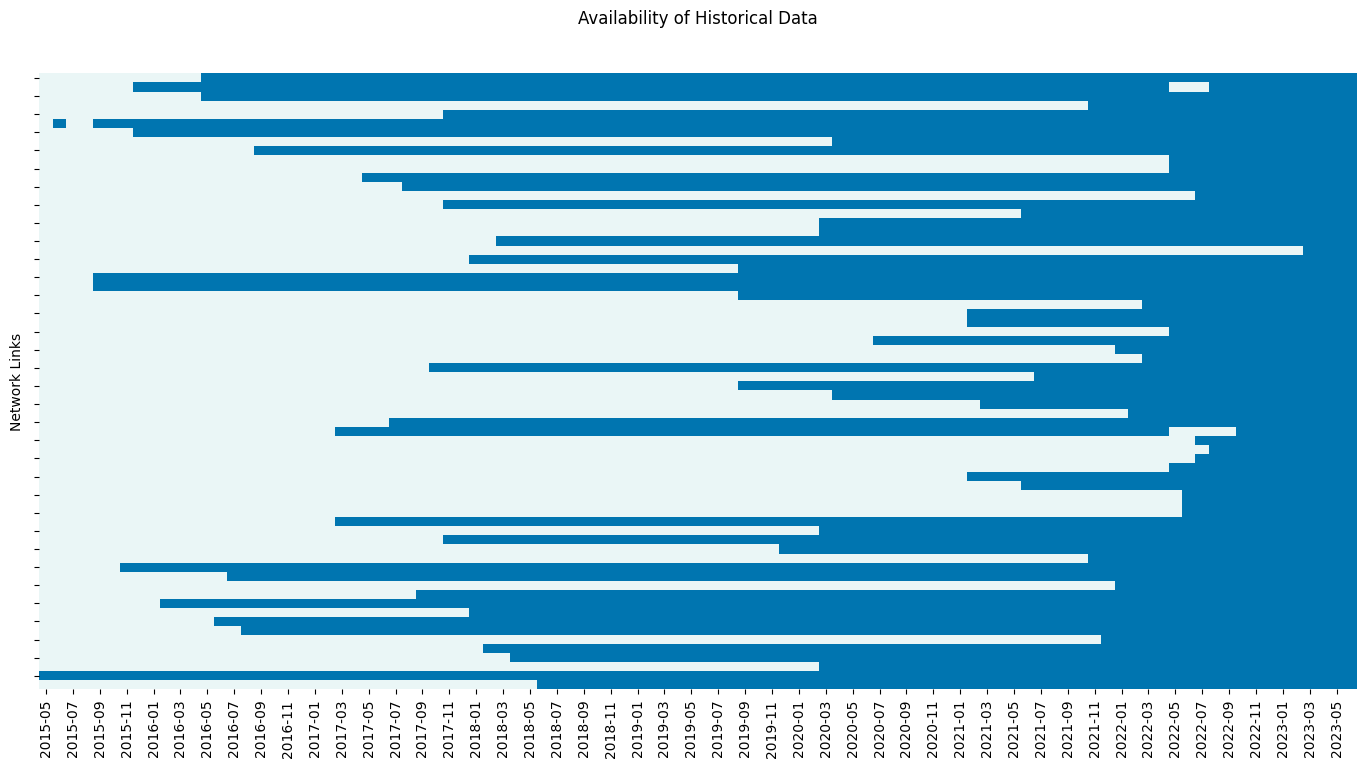

In [20]:
## ------------------------------------------------------------
##                          For the PPT
## ------------------------------------------------------------
fig, axes = plt.subplots(1, 1, figsize=(17, 8))
hm = sns.heatmap(df_pivot.T, cmap=cmap_white_to_blue, cbar=False)
hm.set(yticklabels=[]) 
hm.set(xlabel=None)
hm.set(ylabel="Network Links")
hm.set(title="Availability of Historical Data\n\n")

## 1.5 Selected Dataset

In [32]:
master_df['traffic'] = master_df[['bits_in_max', 'bits_out_max']].max(axis=1)
master_df = master_df.drop('Unnamed: 0', axis=1)
master_df

,month,month_chart,device_name,interface_name,dest_from_alias,base_doc_id,bits_in_max,bits_out_max,traffic
0,2015-05-01,2015-05,rd3ha.ss,Bundle-Ether7,rc3sc.wp,WPSC-1119,7.043480e+09,8.112180e+08,7.043480e+09
1,2015-06-01,2015-06,rc3no.cg,Bundle-Ether12,rd3ht.ok,CGNO-4501,2.651238e+09,6.376355e+09,6.376355e+09
2,2015-06-01,2015-06,rd3ha.ss,Bundle-Ether7,rc3sc.wp,WPSC-1119,8.483581e+09,9.103239e+08,8.483581e+09
3,2015-06-01,2015-06,rd3ht.ok,Bundle-Ether12,rc3no.cg,CGNO-4501,6.384835e+09,2.649271e+09,6.384835e+09
4,2015-07-01,2015-07,rd3ha.ss,Bundle-Ether7,rc3sc.wp,WPSC-1119,8.259827e+09,8.032940e+08,8.259827e+09
...,...,...,...,...,...,...,...,...,...
6157,2023-06-01,2023-06,rds1he.rd,Bundle-Ether9,rc3no.cg,RDHE-567,5.397425e+07,2.114314e+07,5.397425e+07
6158,2023-06-01,2023-06,rds2ha.ss,Bundle-Ether1,rds1ha.ss,SSHA-1317,3.867219e+08,4.006397e+06,3.867219e+08
6159,2023-06-01,2023-06,rds2ha.ss,Bundle-Ether214,rc2ar.ed,SSHA-1324,3.063809e+07,4.464694e+06,3.063809e+07
6160,2023-06-01,2023-06,rds2he.rd,Bundle-Ether2,rds1he.rd,RDHE-574,7.275752e+07,9.789026e+05,7.275752e+07


In [33]:
traffic = master_df[['month', 'month_chart', 'base_doc_id', 'traffic']]\
                .sort_values(by='traffic', ascending=False)\
                .drop_duplicates(subset=['month','month_chart', 'base_doc_id'], keep='first')
traffic

,month,month_chart,base_doc_id,traffic
4309,2022-05-01,2022-05,WAWT-424,1.258350e+12
5137,2022-11-01,2022-11,WAWT-424,1.214031e+12
4303,2022-05-01,2022-05,ILEC-376,1.132778e+12
4447,2022-06-01,2022-06,WAWT-424,1.065028e+12
4441,2022-06-01,2022-06,ILEC-376,1.052778e+12
...,...,...,...,...
5006,2022-10-01,2022-10,GVLP-252,NaN
5144,2022-11-01,2022-11,GVLP-252,NaN
5282,2022-12-01,2022-12,GVLP-252,NaN
5420,2023-01-01,2023-01,GVLP-252,NaN


In [34]:
pivot_traffic = traffic.pivot(index=['month','month_chart'], columns='base_doc_id', values='traffic').reset_index().set_index(['month','month_chart'])
pivot_traffic

,base_doc_id,50086CGWP,50090CGVC,50273CGWP,83322CGVC,CGNO-4298,CGNO-4501,CGNO-4576,CGNO-6389,CGSO-4754,CLSJ-42,...,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WAWT-854,WPNR-2001,WPNR-2009,WPNR-2268,WPSC-1119,WPSC-1733
month,month_chart,,,,,,,,,,,,,,,,,,,,,
2015-05-01,2015-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.043480e+09,NaN
2015-06-01,2015-06,NaN,NaN,NaN,NaN,NaN,6.384835e+09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.483581e+09,NaN
2015-07-01,2015-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.259827e+09,NaN
2015-08-01,2015-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.391569e+09,NaN
2015-09-01,2015-09,NaN,NaN,NaN,NaN,NaN,5.165008e+10,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.029186e+10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,2023-02,1.108639e+11,1.567643e+11,3.450858e+11,1.112497e+10,6.722573e+11,1.492383e+06,8.095689e+10,1.150209e+11,3.121721e+11,1.672623e+10,...,7.549274e+11,4.038878e+11,5.728492e+11,9.538093e+11,101342.007883,1.145954e+11,2.002232e+11,2.472773e+10,1.084028e+11,5.958215e+10
2023-03-01,2023-03,9.002247e+10,1.694706e+11,3.845507e+11,1.171984e+10,6.394669e+11,1.405344e+06,7.329572e+10,1.237233e+11,3.253102e+11,1.842285e+10,...,6.651821e+11,4.534931e+11,5.273066e+11,8.630540e+11,126431.454553,1.273924e+11,1.990759e+11,2.349823e+10,1.101546e+11,7.444165e+10
2023-04-01,2023-04,1.315288e+11,1.796556e+11,3.688267e+11,1.296918e+10,6.199832e+11,0.000000e+00,7.291380e+10,1.402096e+11,3.429554e+11,1.725090e+10,...,7.053346e+11,4.112069e+11,5.453419e+11,8.392284e+11,111873.400151,1.154267e+11,2.408995e+11,2.188033e+10,1.385124e+11,6.173008e+10


### YEARS...

In [35]:
def getHistoricalData(number_of_months=60):
    tmp_df = pd.DataFrame(pivot_traffic.count())
    if number_of_months>0:
        tmp_df = tmp_df[tmp_df[0] >= number_of_months].reset_index()
    else:
        tmp_df = tmp_df.reset_index()
        
    return tmp_df

In [36]:
def getHistoricalData2(number_of_months=60):
    tmp_df = pd.DataFrame(pivot_traffic.count())
    if number_of_months>0:
        tmp_df = tmp_df[tmp_df[0] >= number_of_months].reset_index()
    else:
        tmp_df = tmp_df.reset_index()
    
    traffic.merge(tmp_df, on='base_doc_id').drop([0],axis=1)

In [37]:
number_of_months=60

In [38]:
selected_df = traffic.merge(getHistoricalData(number_of_months), on='base_doc_id').drop([0],axis=1)
selected_df

,month,month_chart,base_doc_id,traffic
0,2022-05-01,2022-05,WAWT-424,1.258350e+12
1,2022-11-01,2022-11,WAWT-424,1.214031e+12
2,2022-06-01,2022-06,WAWT-424,1.065028e+12
3,2021-11-01,2021-11,WAWT-424,9.905194e+11
4,2021-12-01,2021-12,WAWT-424,9.890849e+11
...,...,...,...,...
2342,2017-07-01,2017-07,SSHA-975,7.514098e+08
2343,2017-03-01,2017-03,SSHA-975,0.000000e+00
2344,2017-04-01,2017-04,SSHA-975,0.000000e+00
2345,2017-05-01,2017-05,SSHA-975,0.000000e+00


In [39]:
# Pivot selected dataset
pivot_selected_df = selected_df.pivot(index=['month', 'month_chart'], columns='base_doc_id', values='traffic').reset_index()

# Limit to five years of historical data
from dateutil.relativedelta import relativedelta
starting_date = datetime.datetime.strftime(datetime.datetime.strptime(pivot_selected_df['month'].max(), '%Y-%m-%d') - relativedelta(months=number_of_months-1), '%Y-%m-%d')

pivot_selected_df = pivot_selected_df[pivot_selected_df['month'] >= starting_date].set_index(['month', 'month_chart'])

pivot_selected_df

,base_doc_id,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,EDAR-2222,EDWE-1221,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
month,month_chart,,,,,,,,,,,,,,,,,,,,,
2018-07-01,2018-07,5.185851e+10,6.212124e+10,4.235889e+10,1.818553e+11,3.898373e+10,5.331025e+10,6.682568e+10,4.668917e+10,3.523699e+10,3.260458e+10,...,4.985759e+10,9.037075e+10,1.194766e+11,1.336050e+11,1.876038e+11,2.221026e+11,1.547702e+10,6.664212e+10,3.641131e+10,5.110603e+10
2018-08-01,2018-08,5.440295e+10,7.060407e+10,1.274693e+11,2.203458e+11,3.910355e+10,2.935718e+10,7.997443e+10,5.778068e+10,4.543152e+10,3.477078e+10,...,5.961557e+10,1.034989e+11,1.417322e+11,1.561633e+11,1.987115e+11,2.572459e+11,2.792069e+10,6.289099e+10,2.712582e+10,1.347680e+11
2018-09-01,2018-09,5.667863e+10,9.924177e+10,4.053837e+10,2.287319e+11,3.678189e+10,2.929238e+10,1.176090e+11,6.456093e+10,5.196357e+10,3.804338e+10,...,6.347397e+10,9.825789e+10,1.324399e+11,1.582828e+11,2.082654e+11,2.635986e+11,2.278581e+10,7.009681e+10,1.919660e+10,5.910954e+10
2018-10-01,2018-10,5.955464e+10,8.740577e+10,9.375628e+10,2.503070e+11,3.573482e+10,3.034396e+10,1.057418e+11,6.611632e+10,5.403202e+10,3.705046e+10,...,6.238817e+10,1.021036e+11,1.520174e+11,1.981226e+11,1.995174e+11,3.006394e+11,2.413556e+10,7.555709e+10,2.615796e+10,1.051212e+11
2018-11-01,2018-11,5.870339e+10,9.524256e+10,5.367614e+10,2.451866e+11,3.582858e+10,3.036324e+10,1.287607e+11,6.495857e+10,5.228785e+10,3.725944e+10,...,8.345293e+10,1.075446e+11,1.615805e+11,1.778574e+11,1.951294e+11,2.735054e+11,2.257622e+10,8.823491e+10,2.948816e+10,6.622887e+10
2018-12-01,2018-12,5.903616e+10,1.068241e+11,6.033883e+10,2.453803e+11,3.716667e+10,3.194679e+10,9.889620e+10,5.295744e+10,3.986999e+10,4.049186e+10,...,8.402238e+10,1.030216e+11,1.594009e+11,1.687044e+11,2.005295e+11,2.561456e+11,2.036311e+10,8.579430e+10,3.309816e+10,4.680028e+10
2019-01-01,2019-01,5.538914e+10,9.624662e+10,6.360016e+10,2.211893e+11,3.963452e+10,3.193421e+10,1.044417e+11,5.844880e+10,4.307132e+10,4.168396e+10,...,7.968556e+10,1.037263e+11,1.460491e+11,1.681784e+11,2.021111e+11,2.388492e+11,1.887130e+10,8.093110e+10,3.447585e+10,6.271727e+10
2019-02-01,2019-02,5.332569e+10,9.171683e+10,6.740656e+10,2.438373e+11,3.962368e+10,3.188128e+10,1.139278e+11,5.624712e+10,4.485280e+10,4.378612e+10,...,8.632838e+10,1.082235e+11,1.443363e+11,1.537017e+11,2.166099e+11,2.851979e+11,2.198008e+10,7.801740e+10,3.618981e+10,6.385387e+10
2019-03-01,2019-03,7.179216e+10,1.227777e+11,7.802069e+10,2.596228e+11,4.109393e+10,3.608802e+10,1.147347e+11,5.762866e+10,4.623197e+10,3.902988e+10,...,9.747680e+10,1.075032e+11,1.652768e+11,1.672743e+11,2.060318e+11,2.940218e+11,3.457331e+10,9.417294e+10,3.827358e+10,5.811329e+10


In [40]:
# can do another heatmap if wanted...

# 2. GLOBAL GROWTH ESTIMATE

## 2.1 Total Traffic

In [41]:
total_traffic = selected_df[selected_df['month'] >= starting_date].drop(['base_doc_id'], axis=1).groupby(['month', 'month_chart']).sum().reset_index()
total_traffic.head()

,month,month_chart,traffic
0,2018-07-01,2018-07,2.029800e+12
1,2018-08-01,2018-08,2.475789e+12
2,2018-09-01,2018-09,2.425369e+12
3,2018-10-01,2018-10,2.613429e+12
4,2018-11-01,2018-11,2.713723e+12


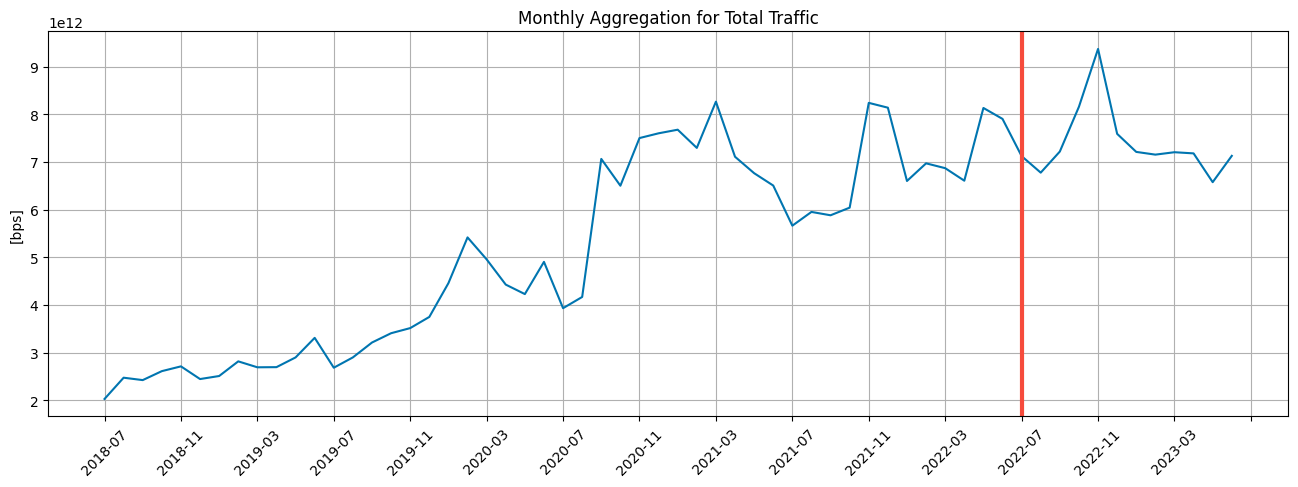

In [42]:
import matplotlib.dates as mdates

plt.figure(figsize=(16,5))
plt.plot(total_traffic.month_chart, total_traffic.traffic, color=color_total_traffic)

plt.axvline(x='2022-07' , color=color_timeline_devider, linewidth=3, label='axvline - full height')

plt.ylabel("[bps]")
plt.title("Monthly Aggregation for Total Traffic")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [43]:
total_traffic['month'] = pd.to_datetime(total_traffic['month'])
total_traffic.head()

,month,month_chart,traffic
0,2018-07-01,2018-07,2.029800e+12
1,2018-08-01,2018-08,2.475789e+12
2,2018-09-01,2018-09,2.425369e+12
3,2018-10-01,2018-10,2.613429e+12
4,2018-11-01,2018-11,2.713723e+12


## 2.2 Train-Test Split

In [44]:
split_value = pivot_selected_df.shape[0] - 12
split_value

48

In [45]:
df_train = total_traffic.sort_values(by='month').loc[:split_value-1]
df_test = total_traffic.sort_values(by='month').loc[(split_value):]
df_test

,month,month_chart,traffic
48,2022-07-01,2022-07,7.125999e+12
49,2022-08-01,2022-08,6.778940e+12
50,2022-09-01,2022-09,7.221722e+12
51,2022-10-01,2022-10,8.161968e+12
52,2022-11-01,2022-11,9.374505e+12
53,2022-12-01,2022-12,7.593037e+12
54,2023-01-01,2023-01,7.214065e+12
55,2023-02-01,2023-02,7.156910e+12
56,2023-03-01,2023-03,7.207401e+12
57,2023-04-01,2023-04,7.183026e+12


In [46]:
df_train.tail()

,month,month_chart,traffic
43,2022-02-01,2022-02,6.974262e+12
44,2022-03-01,2022-03,6.872768e+12
45,2022-04-01,2022-04,6.610095e+12
46,2022-05-01,2022-05,8.136202e+12
47,2022-06-01,2022-06,7.906702e+12


## 2.3 Exponential Regression Model

In [47]:
def expregFnc(df):
    expreg = np.polyfit(df.index + 1, np.log(df.traffic), 1)
    return expreg

In [48]:
expreg = expregFnc(df_train)
print(expreg)

[ 0.02888414 28.45574318]


In [49]:
def YearlyGrowth(expreg_coeff):
    return ((expreg_coeff[0]+1)**12 - 1)*100

In [50]:
YearlyGrowth(expreg)

40.73355306831159

In [51]:
def monthlyCAGR(trainingset, testset, growth=0):
    if growth == 0:
        growth = expregFnc(trainingset)[0]

    # applying growth to the last (i.e. most recent) measurement of training set
    expreg_pred = pd.DataFrame()
    expreg_pred['month'] = testset.month
    expreg_pred['month_chart'] = testset.month_chart
    expreg_pred['traffic'] = (trainingset.loc[trainingset.index[-1], 'traffic']) * \
                            (1 + growth)**(expreg_pred.index - trainingset.index[-1])   
    
    # highest within the past 12 months
    last_hist_yr = trainingset.tail(12)
    expreg_pred['traffic_max'] = (last_hist_yr['traffic'].max()) * \
            (1 + growth)**(expreg_pred.index - last_hist_yr[last_hist_yr.traffic == last_hist_yr['traffic'].max()].index)
    
    # lowest within the past 12 months
    expreg_pred['traffic_min'] = (last_hist_yr['traffic'].min()) * \
            (1 + growth)**(expreg_pred.index - last_hist_yr[last_hist_yr.traffic == last_hist_yr['traffic'].min()].index)
    
    # following regression line
    expreg_fit = pd.DataFrame()
    expreg_fit['month'] = pd.concat([trainingset, testset]).month
    expreg_fit['month_chart'] = pd.concat([trainingset, testset]).month_chart
    expreg_fit['traffic'] = math.exp(expregFnc(trainingset)[1]) * (math.exp(growth)**(pd.concat([trainingset, testset]).reset_index().drop(['index'], axis=1).index + 1))   
    
    return expreg_pred, expreg_fit, growth

In [52]:
expreg_pred, expreg_fit, growth = monthlyCAGR(df_train, df_test)

In [53]:
expreg_pred

,month,month_chart,traffic,traffic_max,traffic_min
48,2022-07-01,2022-07,8.135080e+12,1.035218e+13,7.973837e+12
49,2022-08-01,2022-08,8.370055e+12,1.065119e+13,8.204154e+12
50,2022-09-01,2022-09,8.611817e+12,1.095884e+13,8.441124e+12
51,2022-10-01,2022-10,8.860561e+12,1.127538e+13,8.684938e+12
52,2022-11-01,2022-11,9.116491e+12,1.160106e+13,8.935795e+12
53,2022-12-01,2022-12,9.379813e+12,1.193614e+13,9.193898e+12
54,2023-01-01,2023-01,9.650741e+12,1.228091e+13,9.459456e+12
55,2023-02-01,2023-02,9.929494e+12,1.263563e+13,9.732684e+12
56,2023-03-01,2023-03,1.021630e+13,1.300060e+13,1.001380e+13
57,2023-04-01,2023-04,1.051139e+13,1.337611e+13,1.030304e+13


In [54]:
expreg_fit.head()

,month,month_chart,traffic
0,2018-07-01,2018-07,2.348099e+12
1,2018-08-01,2018-08,2.416911e+12
2,2018-09-01,2018-09,2.487740e+12
3,2018-10-01,2018-10,2.560644e+12
4,2018-11-01,2018-11,2.635684e+12


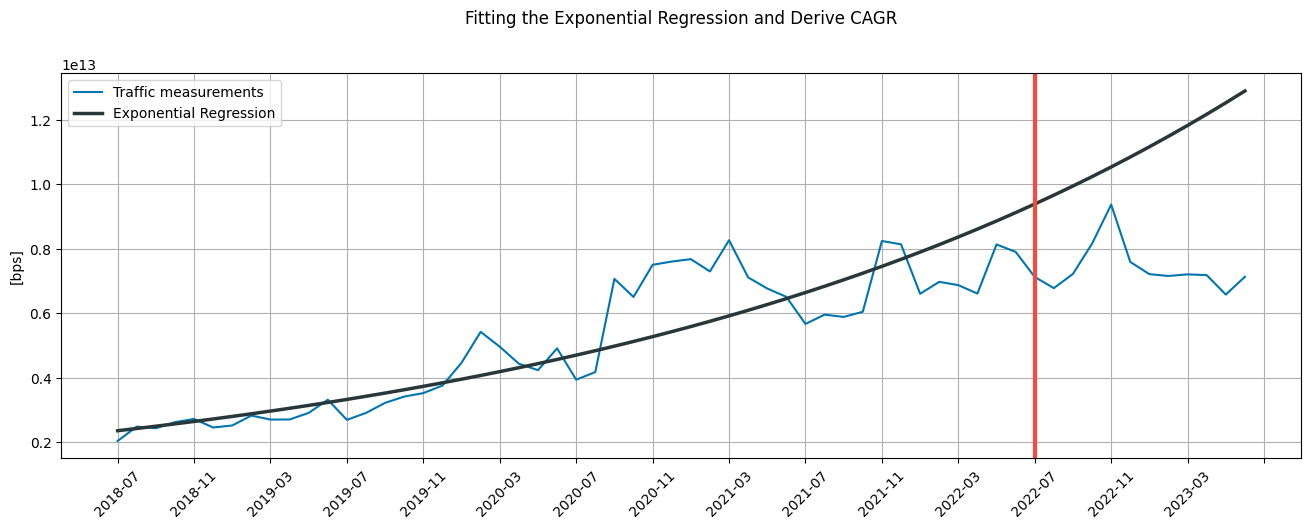

In [55]:
plt.figure(figsize=(16,5))
plt.plot(total_traffic.month_chart, total_traffic.traffic, color=color_total_traffic, label='Traffic measurements')
plt.plot(expreg_fit.month_chart, expreg_fit.traffic, color=color_exp_reg, label='Exponential Regression', linewidth=2.5)
#plt.plot(expreg_pred.month_chart, expreg_pred.traffic, color=color_global_cagr, label='CAGR applied at most recent training value', linewidth=2.5)
#plt.plot(expreg_pred.month_chart, expreg_pred.traffic_max,  color=color_global_cagr, linestyle='--', label='CAGR applied at highest training value', linewidth=2.5)
#plt.plot(expreg_pred.month_chart, expreg_pred.traffic_min, color=color_global_cagr, linestyle='--', label='CAGR applied at lowest training value', linewidth=2.5)

plt.axvline(x='2022-07' , color=color_timeline_devider, linewidth=3)

plt.ylabel('[bps]')
plt.title("Fitting the Exponential Regression and Derive CAGR\n\n")
plt.legend()

plt.annotate('Training Set', xy=(39,14000000000000), xytext=(41, 13800000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.annotate('Test Set', xy=(55,14000000000000), xytext=(49, 13800000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)
plt.grid()
plt.show()

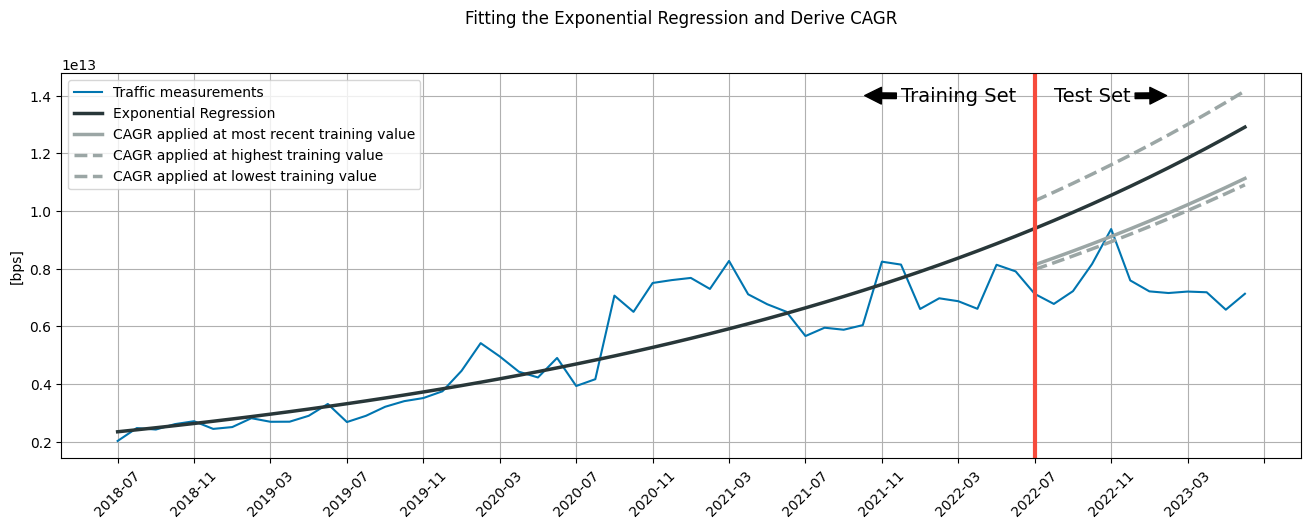

In [56]:
plt.figure(figsize=(16,5))
plt.plot(total_traffic.month_chart, total_traffic.traffic, color=color_total_traffic, label='Traffic measurements')
plt.plot(expreg_fit.month_chart, expreg_fit.traffic, color=color_exp_reg, label='Exponential Regression', linewidth=2.5)
plt.plot(expreg_pred.month_chart, expreg_pred.traffic, color=color_global_cagr, label='CAGR applied at most recent training value', linewidth=2.5)
plt.plot(expreg_pred.month_chart, expreg_pred.traffic_max,  color=color_global_cagr, linestyle='--', label='CAGR applied at highest training value', linewidth=2.5)
plt.plot(expreg_pred.month_chart, expreg_pred.traffic_min, color=color_global_cagr, linestyle='--', label='CAGR applied at lowest training value', linewidth=2.5)

plt.axvline(x='2022-07' , color=color_timeline_devider, linewidth=3)

plt.ylabel('[bps]')
plt.title("Fitting the Exponential Regression and Derive CAGR\n\n")
plt.legend()

plt.annotate('Training Set', xy=(39,14000000000000), xytext=(41, 13800000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.annotate('Test Set', xy=(55,14000000000000), xytext=(49, 13800000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [57]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

def errorExpReg(test, pred):
    MAPE = mean_absolute_percentage_error(test, pred)
    RMSE = np.sqrt(mean_squared_error(test, pred))
    return MAPE, RMSE#dict(MAPE=MAPE, RMSE=RMSE)

def meanvar(ser):
    ser_mean, ser_var = ser.mean(), np.sqrt(ser.var())
    return ser_mean, ser_var

In [58]:
data = []

d = errorExpReg(df_test.traffic, expreg_fit.loc[split_value:].traffic)
data.append(dict(name='Exponential Regression', RMSE=d[1], MAPE=d[0]))

d = errorExpReg(df_test.traffic, expreg_pred.traffic)
data.append(dict(name='CAGR (based on most recent training date)', RMSE=d[1], MAPE=d[0]))

d=errorExpReg(df_test.traffic, expreg_pred.traffic_max)
data.append(dict(name='CAGR (based on max traffic within 12 months of training)', RMSE=d[1], MAPE=d[0]))

d=errorExpReg(df_test.traffic, expreg_pred.traffic_min)
data.append(dict(name='CAGR (based on min within 12 months of training)', RMSE=d[1], MAPE=d[0]))

df = pd.DataFrame(data).set_index('name')
df

,RMSE,MAPE
name,,
Exponential Regression,3.948589e+12,0.511764
CAGR (based on most recent training date),2.531415e+12,0.310620
CAGR (based on max traffic within 12 months of training),5.012398e+12,0.661972
CAGR (based on min within 12 months of training),2.362549e+12,0.287946


In [59]:
# with RMSE higher than variance the predictions do not seem that good
meanvar(df_train.traffic)

(5062146105034.429, 2049548172836.082)

# 3. Exponential Regression on Individual Links

## 3.1 Selected Dataset

In [60]:
pivot_selected_df.head()

,base_doc_id,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,EDAR-2222,EDWE-1221,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
month,month_chart,,,,,,,,,,,,,,,,,,,,,
2018-07-01,2018-07,5.185851e+10,6.212124e+10,4.235889e+10,1.818553e+11,3.898373e+10,5.331025e+10,6.682568e+10,4.668917e+10,3.523699e+10,3.260458e+10,...,4.985759e+10,9.037075e+10,1.194766e+11,1.336050e+11,1.876038e+11,2.221026e+11,1.547702e+10,6.664212e+10,3.641131e+10,5.110603e+10
2018-08-01,2018-08,5.440295e+10,7.060407e+10,1.274693e+11,2.203458e+11,3.910355e+10,2.935718e+10,7.997443e+10,5.778068e+10,4.543152e+10,3.477078e+10,...,5.961557e+10,1.034989e+11,1.417322e+11,1.561633e+11,1.987115e+11,2.572459e+11,2.792069e+10,6.289099e+10,2.712582e+10,1.347680e+11
2018-09-01,2018-09,5.667863e+10,9.924177e+10,4.053837e+10,2.287319e+11,3.678189e+10,2.929238e+10,1.176090e+11,6.456093e+10,5.196357e+10,3.804338e+10,...,6.347397e+10,9.825789e+10,1.324399e+11,1.582828e+11,2.082654e+11,2.635986e+11,2.278581e+10,7.009681e+10,1.919660e+10,5.910954e+10
2018-10-01,2018-10,5.955464e+10,8.740577e+10,9.375628e+10,2.503070e+11,3.573482e+10,3.034396e+10,1.057418e+11,6.611632e+10,5.403202e+10,3.705046e+10,...,6.238817e+10,1.021036e+11,1.520174e+11,1.981226e+11,1.995174e+11,3.006394e+11,2.413556e+10,7.555709e+10,2.615796e+10,1.051212e+11
2018-11-01,2018-11,5.870339e+10,9.524256e+10,5.367614e+10,2.451866e+11,3.582858e+10,3.036324e+10,1.287607e+11,6.495857e+10,5.228785e+10,3.725944e+10,...,8.345293e+10,1.075446e+11,1.615805e+11,1.778574e+11,1.951294e+11,2.735054e+11,2.257622e+10,8.823491e+10,2.948816e+10,6.622887e+10


In [61]:
reset = pivot_selected_df.reset_index().sort_values(by=['month', 'month_chart'])
selected_train = reset.loc[:split_value-1]
selected_test = reset.loc[split_value:]
# selected_train = pivot_selected_df.reset_index().sort_values(by=['month', 'month_chart']).loc[:split_value-1].set_index(['month', 'month_chart'])
# selected_test = pivot_selected_df.reset_index().sort_values(by=['month', 'month_chart']).loc[split_value:].set_index(['month', 'month_chart'])
selected_train.tail()

base_doc_id,month,month_chart,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
43,2022-02-01,2022-02,1.094644e+11,1.955219e+11,3.428532e+11,5.434341e+11,3.777130e+09,9.007793e+10,2.651847e+11,7.714872e+10,...,1.244065e+11,3.196982e+11,6.365160e+11,3.361554e+11,4.559926e+11,7.029205e+11,1.306556e+11,2.772641e+11,1.178040e+11,1.015674e+11
44,2022-03-01,2022-03,1.067831e+11,1.538324e+11,4.005449e+11,5.882993e+11,2.451558e+10,1.041370e+11,2.718599e+11,8.121142e+10,...,1.177773e+11,2.932221e+11,7.042927e+11,3.935169e+11,5.249527e+11,8.120312e+11,9.957186e+10,2.124884e+11,1.009107e+11,8.595268e+10
45,2022-04-01,2022-04,1.050370e+11,1.348699e+11,3.440764e+11,5.146199e+11,5.511224e+09,8.712460e+10,4.098909e+11,7.757980e+10,...,8.320670e+10,2.908942e+11,7.611789e+11,3.858302e+11,4.361448e+11,6.998507e+11,1.042629e+11,2.144121e+11,1.135691e+11,7.809764e+10
46,2022-05-01,2022-05,1.173928e+11,NaN,2.898055e+11,5.599091e+11,8.741850e+09,9.473341e+10,4.799529e+11,9.702223e+10,...,2.329749e+11,2.816820e+11,1.258350e+12,4.753187e+11,4.430626e+11,8.055081e+11,1.078324e+11,1.849302e+11,1.069035e+11,1.026932e+11
47,2022-06-01,2022-06,1.127865e+11,NaN,3.421285e+11,5.646369e+11,8.879094e+09,8.789628e+10,4.550539e+11,9.720055e+10,...,9.699434e+10,2.832713e+11,1.065028e+12,4.359406e+11,4.676471e+11,8.586714e+11,1.188061e+11,1.782643e+11,1.030478e+11,1.293223e+11


In [62]:
selected_test.head()

base_doc_id,month,month_chart,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
48,2022-07-01,2022-07,2.359298e+11,NaN,3.512250e+11,4.905041e+11,4.832280e+09,9.200168e+10,4.719670e+11,9.372068e+10,...,1.479241e+11,3.399088e+11,6.557246e+11,4.351509e+11,4.680600e+11,7.328269e+11,2.057247e+11,2.244710e+11,1.050094e+11,1.405439e+11
49,2022-08-01,2022-08,1.690390e+11,9.931481e+10,2.705777e+11,5.776366e+11,5.031674e+09,1.088809e+11,2.923694e+11,1.048936e+11,...,9.211775e+10,2.974428e+11,6.540106e+11,4.402238e+11,4.423126e+11,8.608377e+11,1.232141e+11,1.925457e+11,1.039473e+11,8.725133e+10
50,2022-09-01,2022-09,1.274603e+11,1.465655e+11,3.110178e+11,6.000476e+11,5.943855e+09,1.073582e+11,3.284571e+11,1.543013e+11,...,1.042891e+11,3.192972e+11,6.429840e+11,4.681840e+11,5.086166e+11,9.069184e+11,1.413312e+11,1.988873e+11,1.076326e+11,9.939650e+10
51,2022-10-01,2022-10,1.187038e+11,1.424533e+11,3.485812e+11,6.755189e+11,1.074823e+10,9.960804e+10,4.626018e+11,7.756259e+10,...,3.947843e+11,3.568488e+11,9.200591e+11,4.191267e+11,5.265644e+11,9.686580e+11,1.429193e+11,2.080698e+11,1.237984e+11,7.292173e+10
52,2022-11-01,2022-11,1.733298e+11,1.827615e+11,3.965647e+11,6.605556e+11,7.185098e+09,7.974391e+10,6.972275e+11,1.027221e+11,...,2.497086e+11,3.060902e+11,1.214031e+12,5.504575e+11,5.079935e+11,9.633737e+11,1.348736e+11,2.450051e+11,1.227351e+11,7.830284e+10


## 3.2 Global CAGR Estimate Applied to Individual Links

In [63]:
globalCAGR_Predictions = pd.DataFrame()
globalCAGR_Predictions['month'] = selected_test.month
globalCAGR_Predictions['month_chart'] = selected_test.month_chart

globalCAGR_Predictions_Max = pd.DataFrame()
globalCAGR_Predictions_Max['month'] = selected_test.month
globalCAGR_Predictions_Max['month_chart'] = selected_test.month_chart

globalCAGR_Predictions_Min = pd.DataFrame()
globalCAGR_Predictions_Min['month'] = selected_test.month
globalCAGR_Predictions_Min['month_chart'] = selected_test.month_chart

globalCAGR_Errors = []

growth = expregFnc(df_train)[0]
for col in selected_train.columns:
    if col not in ['month', 'month_chart']:
        trainingset = pd.DataFrame(selected_train[['month', 'month_chart',col]]).rename(columns={col:'traffic'})
        testset = pd.DataFrame(selected_test[['month', 'month_chart',col]]).rename(columns={col:'traffic'})
            
        clean_train = trainingset.dropna()
        clean_train = clean_train[clean_train.traffic > 0]
    
        clean_test = testset.dropna()
        clean_test = clean_test[clean_test.traffic > 0]
    
        pred = monthlyCAGR(clean_train, testset, growth)
        globalCAGR_Predictions[col], globalCAGR_Predictions_Max[col], globalCAGR_Predictions_Min[col] = pred[0].traffic, pred[0].traffic_max, pred[0].traffic_min

        clean_pred = globalCAGR_Predictions[globalCAGR_Predictions.month.isin(clean_test.month)]
        clean_pred_max = globalCAGR_Predictions_Max[globalCAGR_Predictions_Max.month.isin(clean_test.month)]
        clean_pred_min = globalCAGR_Predictions_Min[globalCAGR_Predictions_Min.month.isin(clean_test.month)]

        globalCAGR_Errors.append( \
            dict(name=col, \
                RMSE=errorExpReg(clean_test.traffic, clean_pred[col])[1], \
                RMSE_max=errorExpReg(clean_test.traffic, clean_pred_max[col])[1], \
                RMSE_min=errorExpReg(clean_test.traffic, clean_pred_min[col])[1], \
                MAPE=errorExpReg(clean_test.traffic, clean_pred[col])[0], \
                MAPE_max=errorExpReg(clean_test.traffic, clean_pred_max[col])[0], \
                MAPE_min=errorExpReg(clean_test.traffic, clean_pred_min[col])[0] \
                ) \
            )
    
#globalCAGR_Predictions    
#globalCAGR_Predictions_Max    
#globalCAGR_Predictions_Min

globalCAGR_Errors = pd.DataFrame(globalCAGR_Errors).set_index('name').T
#globalCAGR_Errors#.loc['RMSE']
globalCAGR_Errors.median(axis=1)
# how come MAPE are so high???

RMSE        5.599695e+10
RMSE_max    1.665707e+11
RMSE_min    5.065778e+10
MAPE        2.785162e-01
MAPE_max    1.077370e+00
MAPE_min    2.456762e-01
dtype: float64

In [64]:
globalCAGR_Errors.max(axis=1)

RMSE        7.421338e+11
RMSE_max    8.780543e+11
RMSE_min    2.012770e+11
MAPE        5.221984e+05
MAPE_max    1.731974e+06
MAPE_min    1.321832e+03
dtype: float64

## 3.3 Explonential Regression Method Directly to Individual Links (Local CAGR)

### Reminder Selected Dataset

In [65]:
selected_train.tail()

base_doc_id,month,month_chart,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
43,2022-02-01,2022-02,1.094644e+11,1.955219e+11,3.428532e+11,5.434341e+11,3.777130e+09,9.007793e+10,2.651847e+11,7.714872e+10,...,1.244065e+11,3.196982e+11,6.365160e+11,3.361554e+11,4.559926e+11,7.029205e+11,1.306556e+11,2.772641e+11,1.178040e+11,1.015674e+11
44,2022-03-01,2022-03,1.067831e+11,1.538324e+11,4.005449e+11,5.882993e+11,2.451558e+10,1.041370e+11,2.718599e+11,8.121142e+10,...,1.177773e+11,2.932221e+11,7.042927e+11,3.935169e+11,5.249527e+11,8.120312e+11,9.957186e+10,2.124884e+11,1.009107e+11,8.595268e+10
45,2022-04-01,2022-04,1.050370e+11,1.348699e+11,3.440764e+11,5.146199e+11,5.511224e+09,8.712460e+10,4.098909e+11,7.757980e+10,...,8.320670e+10,2.908942e+11,7.611789e+11,3.858302e+11,4.361448e+11,6.998507e+11,1.042629e+11,2.144121e+11,1.135691e+11,7.809764e+10
46,2022-05-01,2022-05,1.173928e+11,NaN,2.898055e+11,5.599091e+11,8.741850e+09,9.473341e+10,4.799529e+11,9.702223e+10,...,2.329749e+11,2.816820e+11,1.258350e+12,4.753187e+11,4.430626e+11,8.055081e+11,1.078324e+11,1.849302e+11,1.069035e+11,1.026932e+11
47,2022-06-01,2022-06,1.127865e+11,NaN,3.421285e+11,5.646369e+11,8.879094e+09,8.789628e+10,4.550539e+11,9.720055e+10,...,9.699434e+10,2.832713e+11,1.065028e+12,4.359406e+11,4.676471e+11,8.586714e+11,1.188061e+11,1.782643e+11,1.030478e+11,1.293223e+11


In [66]:
selected_test.head()

base_doc_id,month,month_chart,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
48,2022-07-01,2022-07,2.359298e+11,NaN,3.512250e+11,4.905041e+11,4.832280e+09,9.200168e+10,4.719670e+11,9.372068e+10,...,1.479241e+11,3.399088e+11,6.557246e+11,4.351509e+11,4.680600e+11,7.328269e+11,2.057247e+11,2.244710e+11,1.050094e+11,1.405439e+11
49,2022-08-01,2022-08,1.690390e+11,9.931481e+10,2.705777e+11,5.776366e+11,5.031674e+09,1.088809e+11,2.923694e+11,1.048936e+11,...,9.211775e+10,2.974428e+11,6.540106e+11,4.402238e+11,4.423126e+11,8.608377e+11,1.232141e+11,1.925457e+11,1.039473e+11,8.725133e+10
50,2022-09-01,2022-09,1.274603e+11,1.465655e+11,3.110178e+11,6.000476e+11,5.943855e+09,1.073582e+11,3.284571e+11,1.543013e+11,...,1.042891e+11,3.192972e+11,6.429840e+11,4.681840e+11,5.086166e+11,9.069184e+11,1.413312e+11,1.988873e+11,1.076326e+11,9.939650e+10
51,2022-10-01,2022-10,1.187038e+11,1.424533e+11,3.485812e+11,6.755189e+11,1.074823e+10,9.960804e+10,4.626018e+11,7.756259e+10,...,3.947843e+11,3.568488e+11,9.200591e+11,4.191267e+11,5.265644e+11,9.686580e+11,1.429193e+11,2.080698e+11,1.237984e+11,7.292173e+10
52,2022-11-01,2022-11,1.733298e+11,1.827615e+11,3.965647e+11,6.605556e+11,7.185098e+09,7.974391e+10,6.972275e+11,1.027221e+11,...,2.497086e+11,3.060902e+11,1.214031e+12,5.504575e+11,5.079935e+11,9.633737e+11,1.348736e+11,2.450051e+11,1.227351e+11,7.830284e+10


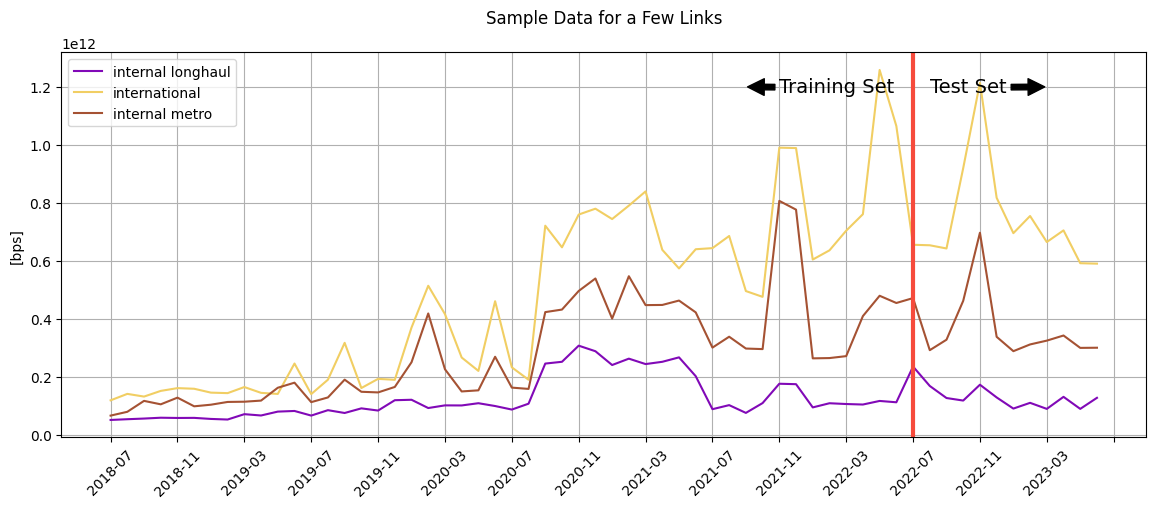

In [67]:
plt.figure(figsize=(14,5))
df = pd.concat([selected_train, selected_test])

plt.plot(df.month_chart, df[tx_sys_longhaul], color=color_longhaul, label='internal longhaul')
plt.plot(df.month_chart, df[tx_sys_international], color=color_intl, label='international')
plt.plot(df.month_chart, df[tx_sys_metro], color=color_metro, label='internal metro')

plt.axvline(x='2022-07', color=color_timeline_devider, linewidth=3)

plt.ylabel("[bps]")
plt.title("Sample Data for a Few Links\n")

plt.annotate('Training Set', xy=(38,1200000000000), xytext=(40, 1180000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.annotate('Test Set', xy=(56,1200000000000), xytext=(49, 1180000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

### 3.3.1 Global vs Local CAGR

In [71]:
globalCAGR_Errors = []
globalCAGR_Errors.append( \
    dict(name=col, \
        RMSE=errorExpReg(clean_test.traffic, clean_pred[col])[1], \
        RMSE_max=errorExpReg(clean_test.traffic, clean_pred_max[col])[1], \
        RMSE_min=errorExpReg(clean_test.traffic, clean_pred_min[col])[1], \
        MAPE=errorExpReg(clean_test.traffic, clean_pred[col])[0], \
        MAPE_max=errorExpReg(clean_test.traffic, clean_pred_max[col])[0], \
        MAPE_min=errorExpReg(clean_test.traffic, clean_pred_min[col])[0] \
    ) \
)
    
#globalCAGR_Predictions    
#globalCAGR_Predictions_Max    
#globalCAGR_Predictions_Min

globalCAGR_Errors = pd.DataFrame(globalCAGR_Errors).set_index('name').T
#globalCAGR_Errors#.loc['RMSE']
globalCAGR_Errors.median(axis=1)



def expregFnc(df):
    expreg = np.polyfit(df.index + 1, np.log(df.traffic), 1)
    return expreg


35.22393683330565 25.639149635782243


RegrLine-pred stats
 RMSE    1.311476e+11
MAPE    5.982854e-01
MEAN    1.397102e+11
STD     5.673209e+10
dtype: float64


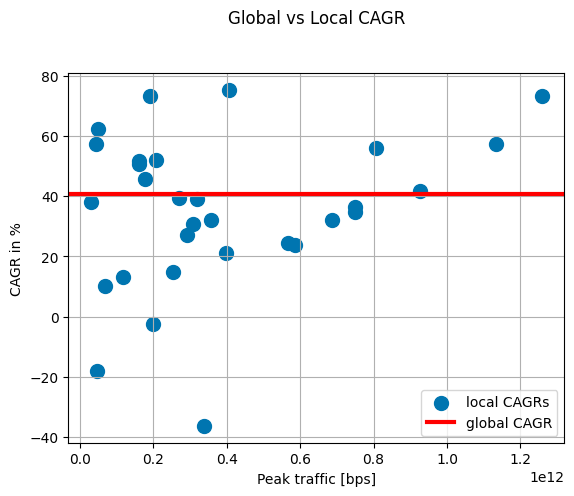

In [72]:
YearlyGrowths = []
localCAGR_FitErrors = []

for col in selected_train.columns:
    if col not in ['month', 'month_chart']:
        trainingset = pd.DataFrame(selected_train[['month', 'month_chart',col]]).rename(columns={col:'traffic'})
        testset = pd.DataFrame(selected_test[['month', 'month_chart',col]]).rename(columns={col:'traffic'})
            
        clean_train = trainingset.dropna()
        clean_train = clean_train[clean_train.traffic > 0]
        historical_max = clean_train['traffic'].max()
    
        clean_test = testset.dropna()
        clean_test = clean_test[clean_test.traffic > 0]

        fitExpReg = expregFnc(clean_train)
        YearlyGrowths.append((col, fitExpReg[0], fitExpReg[1], YearlyGrowth(fitExpReg), historical_max))
        
        fit = monthlyCAGR(clean_train, testset, growth)
        clean_fit = fit[1].loc[split_value:]
        clean_fit = clean_fit[clean_fit.month.isin(clean_test.month)]
        localCAGR_FitErrors.append( \
            dict(name=col, \
                RMSE=errorExpReg(clean_test.traffic, clean_fit.traffic)[1], \
                MAPE=errorExpReg(clean_test.traffic, clean_fit.traffic)[0], \
                MEAN=fit[1].loc[:split_value].traffic.mean(), \
                STD=fit[1].loc[:split_value].traffic.std()
                ) \
            )

YearlyGrowths = pd.DataFrame(YearlyGrowths, columns=['base_doc_id', 'mthG', 'I', 'yrG', 'peak'])
meanCAGR = YearlyGrowths.yrG.mean()
varCAGR = YearlyGrowths.yrG.std()
print(meanCAGR, varCAGR) #variance too high

localCAGR_FitErrors = pd.DataFrame(localCAGR_FitErrors).set_index('name').T
print('\n\nRegrLine-pred stats\n', localCAGR_FitErrors.median(axis=1))

plt.scatter(YearlyGrowths.peak, YearlyGrowths.yrG, s=100, label='local CAGRs', color=color_total_traffic)
plt.axhline(y=[YearlyGrowth(expreg)], xmin=0.0, xmax=1.0, color='r', linewidth=3, label='global CAGR')
plt.legend()
plt.title('Global vs Local CAGR\n\n')
plt.ylabel('CAGR in %')
plt.xlabel("Peak traffic [bps]")
# plt.xticks([""])
plt.grid()
plt.show()

### 3.3.2 Internal Long Haul Link - '50086CGWP'

In [73]:
tx_sys_longhaul

'50086CGWP'

In [74]:
tx_sys = tx_sys_longhaul #50086CGWP

In [75]:
longhaul_train = pd.DataFrame(selected_train[['month', 'month_chart',tx_sys]]).rename(columns={tx_sys:'traffic'})
longhaul_train.head()

base_doc_id,month,month_chart,traffic
0,2018-07-01,2018-07,5.185851e+10
1,2018-08-01,2018-08,5.440295e+10
2,2018-09-01,2018-09,5.667863e+10
3,2018-10-01,2018-10,5.955464e+10
4,2018-11-01,2018-11,5.870339e+10


In [76]:
longhaul_test = pd.DataFrame(selected_test[['month', 'month_chart',tx_sys]]).rename(columns={tx_sys:'traffic'})
longhaul_test['traffic']#.head()

48    2.359298e+11
49    1.690390e+11
50    1.274603e+11
51    1.187038e+11
52    1.733298e+11
53    1.294941e+11
54    9.105656e+10
55    1.108639e+11
56    9.002247e+10
57    1.315288e+11
58    9.002516e+10
59    1.281332e+11
Name: traffic, dtype: float64

In [77]:
LH_regexp_pred, LH_regexp_fit, LH_regexp_growth = monthlyCAGR(longhaul_train, longhaul_test)
#LH_regexp_pred
#LH_regexp_fit.reset_index()
#LH_regexp_growth

In [78]:
# errors

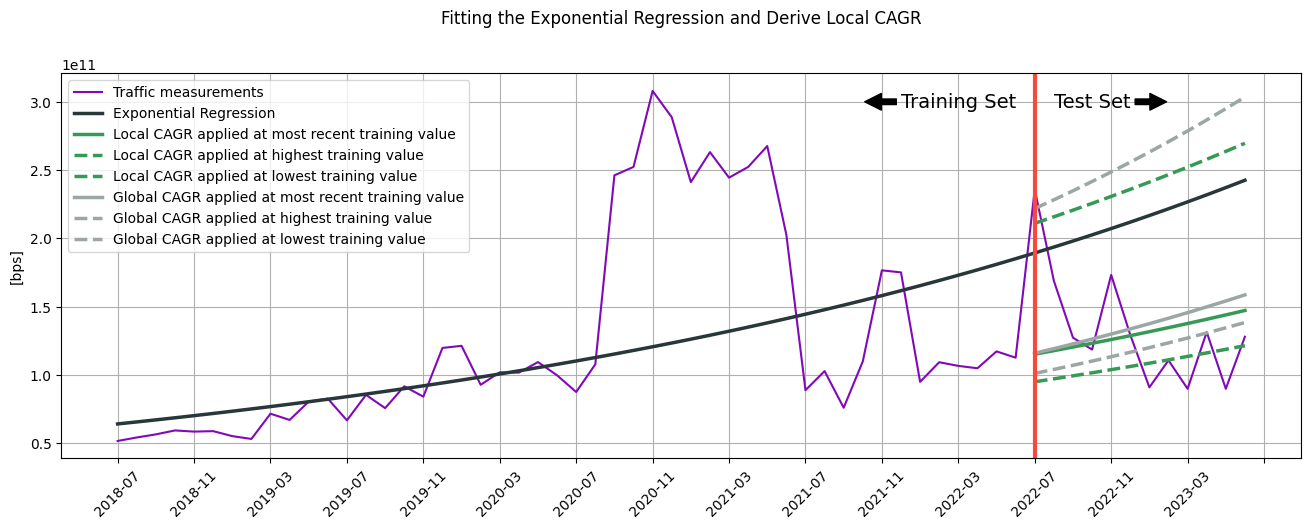

In [79]:
## longhaul link

plt.figure(figsize=(16,5))
df_longhaul = pd.concat([longhaul_train, longhaul_test])

plt.plot(df_longhaul.month_chart, df_longhaul.traffic, color=color_longhaul, label='Traffic measurements')
plt.plot(LH_regexp_fit.month_chart, LH_regexp_fit.traffic, color=color_exp_reg, label='Exponential Regression', linewidth=2.5)
plt.plot(LH_regexp_pred.month_chart, LH_regexp_pred.traffic, color=color_local_cagr, label='Local CAGR applied at most recent training value', linewidth=2.5)
plt.plot(LH_regexp_pred.month_chart, LH_regexp_pred.traffic_max, color=color_local_cagr, linestyle='--', label='Local CAGR applied at highest training value', linewidth=2.5)
plt.plot(LH_regexp_pred.month_chart, LH_regexp_pred.traffic_min, color=color_local_cagr, linestyle='--', label='Local CAGR applied at lowest training value', linewidth=2.5)

globalCAGR = pd.DataFrame([globalCAGR_Predictions.month, globalCAGR_Predictions.month_chart, globalCAGR_Predictions[tx_sys]]).T
plt.plot(globalCAGR.month_chart, globalCAGR[tx_sys], color=color_global_cagr, label='Global CAGR applied at most recent training value', linewidth=2.5)
plt.plot(globalCAGR_Predictions_Max.month_chart, globalCAGR_Predictions_Max[tx_sys], color=color_global_cagr, linestyle='--', label='Global CAGR applied at highest training value', linewidth=2.5)
plt.plot(globalCAGR_Predictions_Min.month_chart, globalCAGR_Predictions_Min[tx_sys], color=color_global_cagr, linestyle='--', label='Global CAGR applied at lowest training value', linewidth=2.5)

plt.axvline(x='2022-07' , color=color_timeline_devider, linewidth=3)

plt.annotate('Training Set', xy=(39,300000000000), xytext=(41,  296000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.annotate('Test Set', xy=(55,300000000000), xytext=(49, 296000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.ylabel('[bps]')
plt.title("Fitting the Exponential Regression and Derive Local CAGR\n\n")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)
plt.grid()
plt.show()

### 3.3.3 International Link - 'WAWT-424'

In [80]:
tx_sys = tx_sys_international #WAWT-424

In [81]:
international_train = pd.DataFrame(selected_train[['month', 'month_chart',tx_sys]]).rename(columns={tx_sys:'traffic'})
international_train.head()

base_doc_id,month,month_chart,traffic
0,2018-07-01,2018-07,1.194766e+11
1,2018-08-01,2018-08,1.417322e+11
2,2018-09-01,2018-09,1.324399e+11
3,2018-10-01,2018-10,1.520174e+11
4,2018-11-01,2018-11,1.615805e+11


In [82]:
international_test = pd.DataFrame(selected_test[['month', 'month_chart',tx_sys]]).rename(columns={tx_sys:'traffic'})
international_test.head()

base_doc_id,month,month_chart,traffic
48,2022-07-01,2022-07,6.557246e+11
49,2022-08-01,2022-08,6.540106e+11
50,2022-09-01,2022-09,6.429840e+11
51,2022-10-01,2022-10,9.200591e+11
52,2022-11-01,2022-11,1.214031e+12


In [83]:
inter_regexp_pred, inter_regexp_fit, inter_regexp_growth = monthlyCAGR(international_train, international_test)
#inter_regexp_pred
#inter_regexp_fit.reset_index()
#inter_regexp_growth

In [84]:
# errors

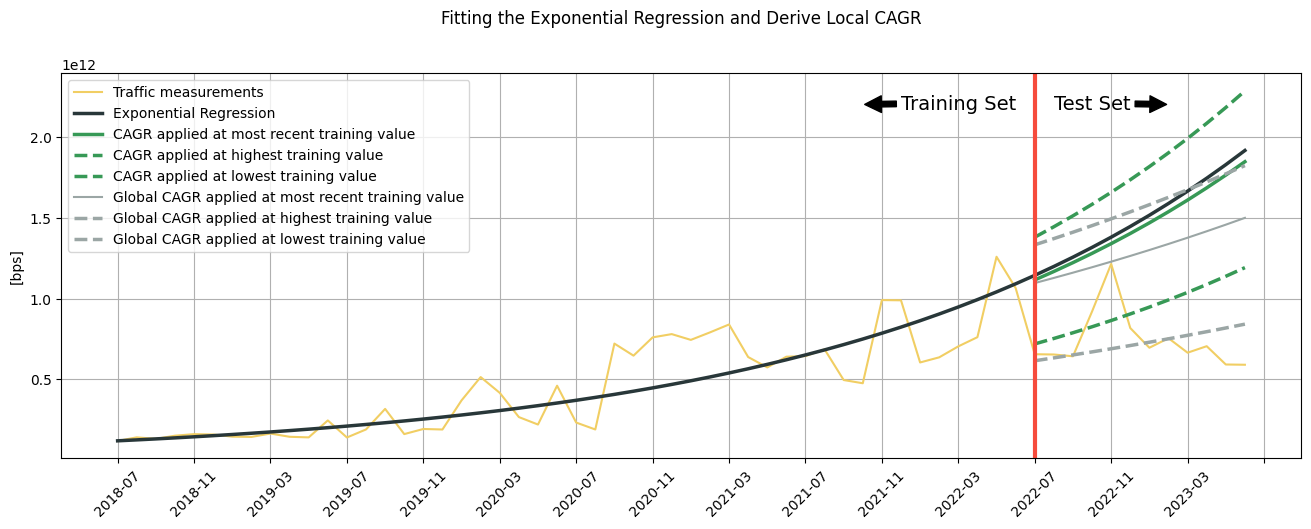

In [85]:
## international link
plt.figure(figsize=(16,5))
df_international = pd.concat([international_train, international_test])

plt.plot(df_international.month_chart, df_international.traffic, color=color_intl, label='Traffic measurements')
plt.plot(inter_regexp_fit.month_chart, inter_regexp_fit.traffic, color=color_exp_reg, label='Exponential Regression', linewidth=2.5)
plt.plot(inter_regexp_pred.month_chart, inter_regexp_pred.traffic, color=color_local_cagr, label='CAGR applied at most recent training value', linewidth=2.5)
plt.plot(inter_regexp_pred.month_chart, inter_regexp_pred.traffic_max,  color=color_local_cagr, linestyle='--', label='CAGR applied at highest training value', linewidth=2.5)
plt.plot(inter_regexp_pred.month_chart, inter_regexp_pred.traffic_min,  color=color_local_cagr, linestyle='--', label='CAGR applied at lowest training value', linewidth=2.5)

globalCAGR = pd.DataFrame([globalCAGR_Predictions.month, globalCAGR_Predictions.month_chart, globalCAGR_Predictions[tx_sys]]).T
plt.plot(globalCAGR.month_chart, globalCAGR[tx_sys], color=color_global_cagr, label='Global CAGR applied at most recent training value')
plt.plot(globalCAGR_Predictions_Max.month_chart, globalCAGR_Predictions_Max[tx_sys], color=color_global_cagr, linestyle='--', label='Global CAGR applied at highest training value', linewidth=2.5)
plt.plot(globalCAGR_Predictions_Min.month_chart, globalCAGR_Predictions_Min[tx_sys], color=color_global_cagr, linestyle='--', label='Global CAGR applied at lowest training value', linewidth=2.5)

plt.axvline(x='2022-07',  color=color_timeline_devider, linewidth=3)

plt.annotate('Training Set', xy=(39,2200000000000), xytext=(41,  2170000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.annotate('Test Set', xy=(55,2200000000000), xytext=(49, 2170000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.ylabel('[bps]')
plt.title("Fitting the Exponential Regression and Derive Local CAGR\n\n")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)
plt.grid()
plt.show()

### 3.3.4 Internal Metro Link - 'CGSO-4754'

In [86]:
tx_sys = tx_sys_metro #CGSO-4754'

In [87]:
metro_train = pd.DataFrame(selected_train[['month', 'month_chart',tx_sys]]).rename(columns={tx_sys:'traffic'})
metro_train.head()

base_doc_id,month,month_chart,traffic
0,2018-07-01,2018-07,6.682568e+10
1,2018-08-01,2018-08,7.997443e+10
2,2018-09-01,2018-09,1.176090e+11
3,2018-10-01,2018-10,1.057418e+11
4,2018-11-01,2018-11,1.287607e+11


In [88]:
metro_test = pd.DataFrame(selected_test[['month', 'month_chart',tx_sys]]).rename(columns={tx_sys:'traffic'})
metro_test.index = [*range(metro_train.shape[0],metro_train.shape[0]+metro_test.shape[0])]
metro_test.head()

base_doc_id,month,month_chart,traffic
48,2022-07-01,2022-07,4.719670e+11
49,2022-08-01,2022-08,2.923694e+11
50,2022-09-01,2022-09,3.284571e+11
51,2022-10-01,2022-10,4.626018e+11
52,2022-11-01,2022-11,6.972275e+11


In [89]:
metro_regexp_pred, metro_regexp_fit, metro_regexp_growth = monthlyCAGR(metro_train, metro_test)
#metro_regexp_pred
#metro_regexp_fit.reset_index()
#metro_regexp_growth

In [90]:
# errors

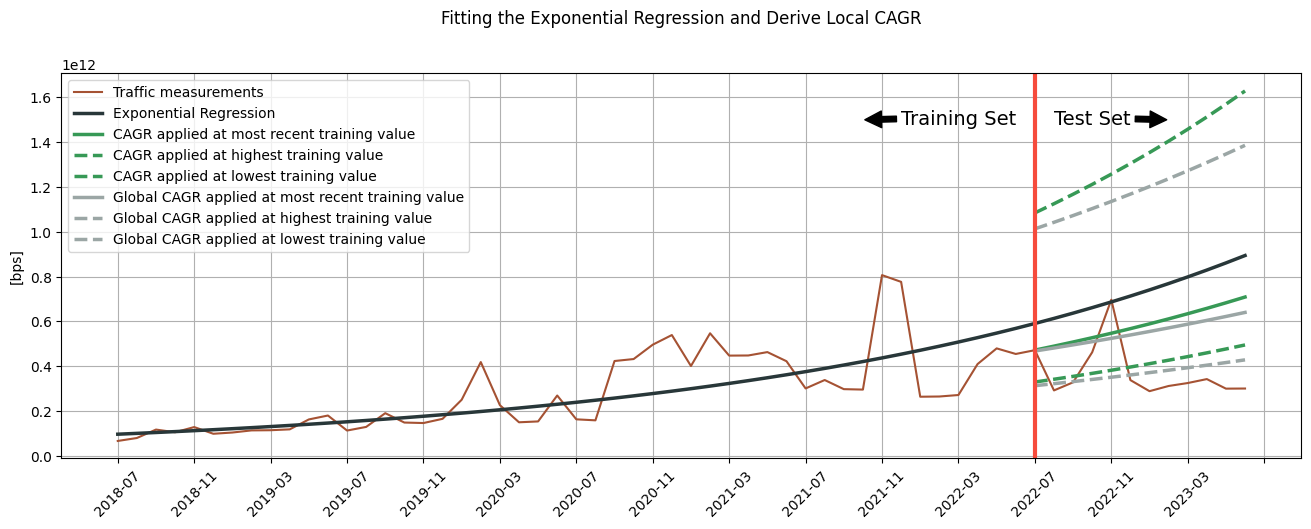

In [91]:
## metro link
plt.figure(figsize=(16,5))

df_metro = pd.concat([metro_train, metro_test])
plt.plot(df_metro.month_chart, df_metro.traffic, color=color_metro, label='Traffic measurements')
plt.plot(metro_regexp_fit.month_chart, metro_regexp_fit.traffic, color=color_exp_reg, label='Exponential Regression', linewidth=2.5)
plt.plot(metro_regexp_pred.month_chart, metro_regexp_pred.traffic, color=color_local_cagr, label='CAGR applied at most recent training value', linewidth=2.5)
plt.plot(metro_regexp_pred.month_chart, metro_regexp_pred.traffic_max, color=color_local_cagr, linestyle='--', label='CAGR applied at highest training value', linewidth=2.5)
plt.plot(metro_regexp_pred.month_chart, metro_regexp_pred.traffic_min, color=color_local_cagr, linestyle='--', label='CAGR applied at lowest training value', linewidth=2.5)

globalCAGR = pd.DataFrame([globalCAGR_Predictions.month, globalCAGR_Predictions.month_chart, globalCAGR_Predictions[tx_sys]]).T
plt.plot(globalCAGR.month_chart, globalCAGR[tx_sys], color=color_global_cagr, label='Global CAGR applied at most recent training value', linewidth=2.5)
plt.plot(globalCAGR_Predictions_Max.month_chart, globalCAGR_Predictions_Max[tx_sys], color=color_global_cagr, linestyle='--', label='Global CAGR applied at highest training value', linewidth=2.5)
plt.plot(globalCAGR_Predictions_Min.month_chart, globalCAGR_Predictions_Min[tx_sys], color=color_global_cagr, linestyle='--', label='Global CAGR applied at lowest training value', linewidth=2.5)

plt.axvline(x='2022-07' , color=color_timeline_devider, linewidth=3)

plt.annotate('Training Set', xy=(39,1500000000000), xytext=(41,  1480000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.annotate('Test Set', xy=(55,1500000000000), xytext=(49, 1480000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.ylabel('[bps]')
plt.title("Fitting the Exponential Regression and Derive Local CAGR\n\n")
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)
plt.grid()
plt.show()

# 4. ML Trials

## 4.1 Recall Datasets

In [92]:
# aggregated traffic
total_traffic.head()

,month,month_chart,traffic
0,2018-07-01,2018-07,2.029800e+12
1,2018-08-01,2018-08,2.475789e+12
2,2018-09-01,2018-09,2.425369e+12
3,2018-10-01,2018-10,2.613429e+12
4,2018-11-01,2018-11,2.713723e+12


In [93]:
# selected dataset
pivot_selected_df.head()

,base_doc_id,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,EDAR-2222,EDWE-1221,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
month,month_chart,,,,,,,,,,,,,,,,,,,,,
2018-07-01,2018-07,5.185851e+10,6.212124e+10,4.235889e+10,1.818553e+11,3.898373e+10,5.331025e+10,6.682568e+10,4.668917e+10,3.523699e+10,3.260458e+10,...,4.985759e+10,9.037075e+10,1.194766e+11,1.336050e+11,1.876038e+11,2.221026e+11,1.547702e+10,6.664212e+10,3.641131e+10,5.110603e+10
2018-08-01,2018-08,5.440295e+10,7.060407e+10,1.274693e+11,2.203458e+11,3.910355e+10,2.935718e+10,7.997443e+10,5.778068e+10,4.543152e+10,3.477078e+10,...,5.961557e+10,1.034989e+11,1.417322e+11,1.561633e+11,1.987115e+11,2.572459e+11,2.792069e+10,6.289099e+10,2.712582e+10,1.347680e+11
2018-09-01,2018-09,5.667863e+10,9.924177e+10,4.053837e+10,2.287319e+11,3.678189e+10,2.929238e+10,1.176090e+11,6.456093e+10,5.196357e+10,3.804338e+10,...,6.347397e+10,9.825789e+10,1.324399e+11,1.582828e+11,2.082654e+11,2.635986e+11,2.278581e+10,7.009681e+10,1.919660e+10,5.910954e+10
2018-10-01,2018-10,5.955464e+10,8.740577e+10,9.375628e+10,2.503070e+11,3.573482e+10,3.034396e+10,1.057418e+11,6.611632e+10,5.403202e+10,3.705046e+10,...,6.238817e+10,1.021036e+11,1.520174e+11,1.981226e+11,1.995174e+11,3.006394e+11,2.413556e+10,7.555709e+10,2.615796e+10,1.051212e+11
2018-11-01,2018-11,5.870339e+10,9.524256e+10,5.367614e+10,2.451866e+11,3.582858e+10,3.036324e+10,1.287607e+11,6.495857e+10,5.228785e+10,3.725944e+10,...,8.345293e+10,1.075446e+11,1.615805e+11,1.778574e+11,1.951294e+11,2.735054e+11,2.257622e+10,8.823491e+10,2.948816e+10,6.622887e+10


## 4.2 Seasonal-Trend Decomposition

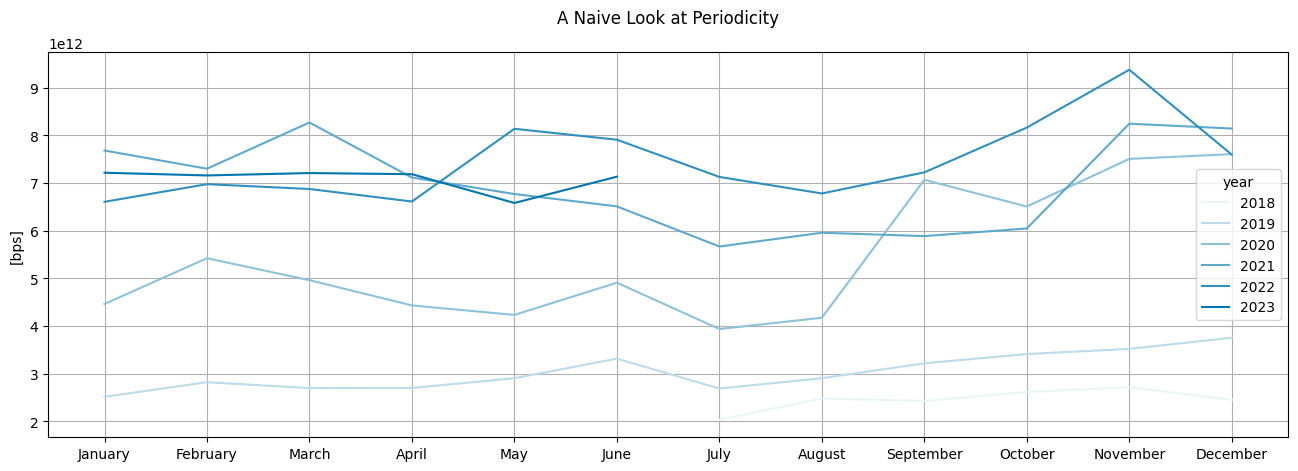

In [95]:
total_traffic_2 = total_traffic
total_traffic_2['year'] = total_traffic_2['month'].dt.year
total_traffic_2['month_str'] = total_traffic_2['month'].dt.strftime('%B')
total_traffic_2['month_int'] = total_traffic_2['month'].dt.month

month_list = [''] + total_traffic_2[['month_int', 'month_str']].drop_duplicates().reset_index().sort_values(by='month_int')['month_str'].to_list()

plt.figure(figsize=(16,5))

cmap_blue = mp_colors.LinearSegmentedColormap.from_list("", [color_blue_white, color_total_traffic])
lc_seasonal = sns.lineplot(data=total_traffic_2, x='month_int', y='traffic', hue='year', palette=cmap_blue)
lc_seasonal.xaxis.set_major_locator(ticker.MultipleLocator(1))
lc_seasonal.set(xticklabels=month_list) 
lc_seasonal.set_xlabel('')
lc_seasonal.set_ylabel('[bps]')
lc_seasonal.set_title('A Naive Look at Periodicity\n')
plt.grid()

In [97]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [98]:
def stl(df, model='multiplicative', title = '', color = 'b'):
    df.index = pd.to_datetime(df.month)   
    se_de_result = seasonal_decompose(df.traffic, model=model, period=12)

    observed = se_de_result.observed
    trend = se_de_result.trend
    seasonal = se_de_result.seasonal
    resid = se_de_result.resid
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    axes[0].plot(observed, color=color)
    axes[0].set_ylabel('Observed')
    axes[1].plot(trend, color=color)
    axes[1].set_ylabel('Trend')
    axes[2].plot(seasonal, color=color)
    axes[2].set_ylabel('Seasonal')
#     axes[3].axhline(y=0,  color=color_gray, linewidth=2)
    axes[3].scatter(resid.index, resid.values, color=color)
    axes[3].set_ylabel('Resid')
    
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
        ax.grid()
        
#     for ax in axes[:len(axes)-1]:
#         ax.set_xticklabels([])
        
    plt.xticks(rotation=45)
    fig.suptitle(title)
    

### 4.2.1 Over Total Traffic

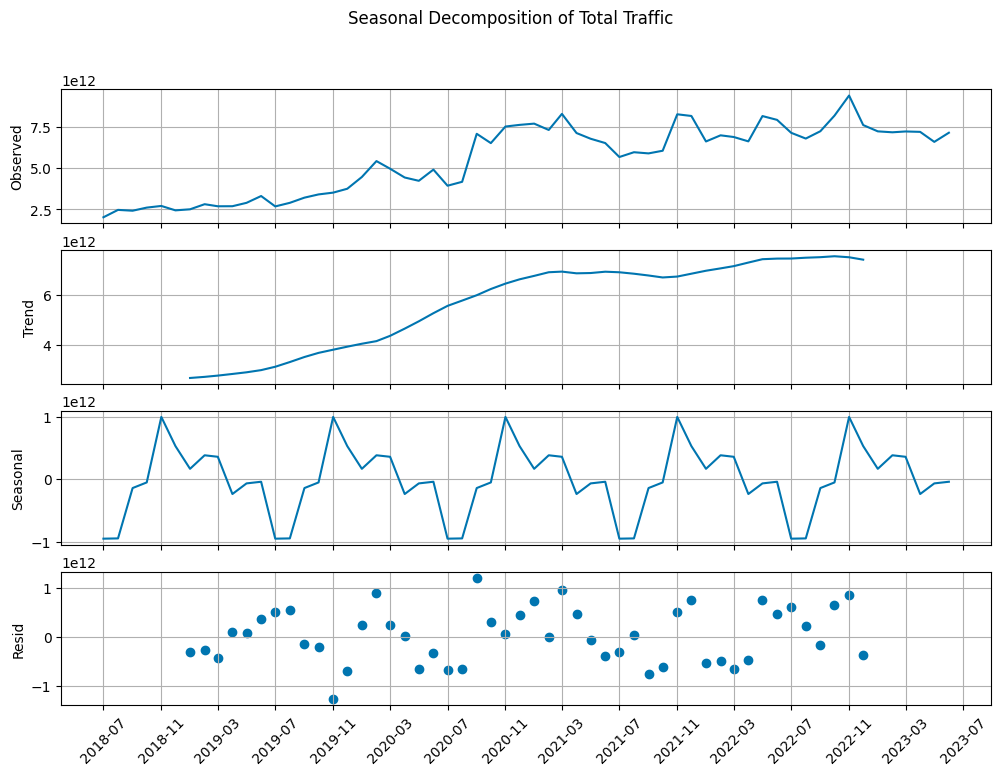

In [99]:
# ADDITIVE
stl(total_traffic, model='additive', title='Seasonal Decomposition of Total Traffic', color=color_total_traffic)

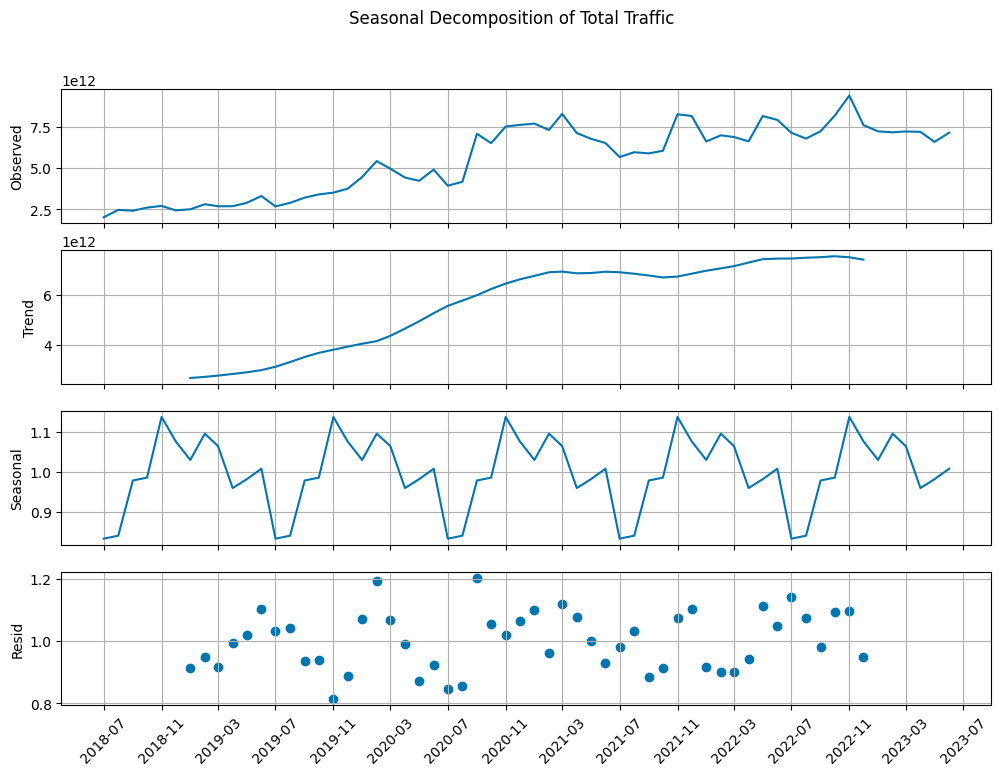

In [100]:
# MULTIPLICATIVE
stl(total_traffic, title='Seasonal Decomposition of Total Traffic', color=color_total_traffic);

### 4.2.2 Individual Link Insight - '50086CGWP'

##### Decomposition 

In [101]:
## long haul
tx_sys = tx_sys_longhaul

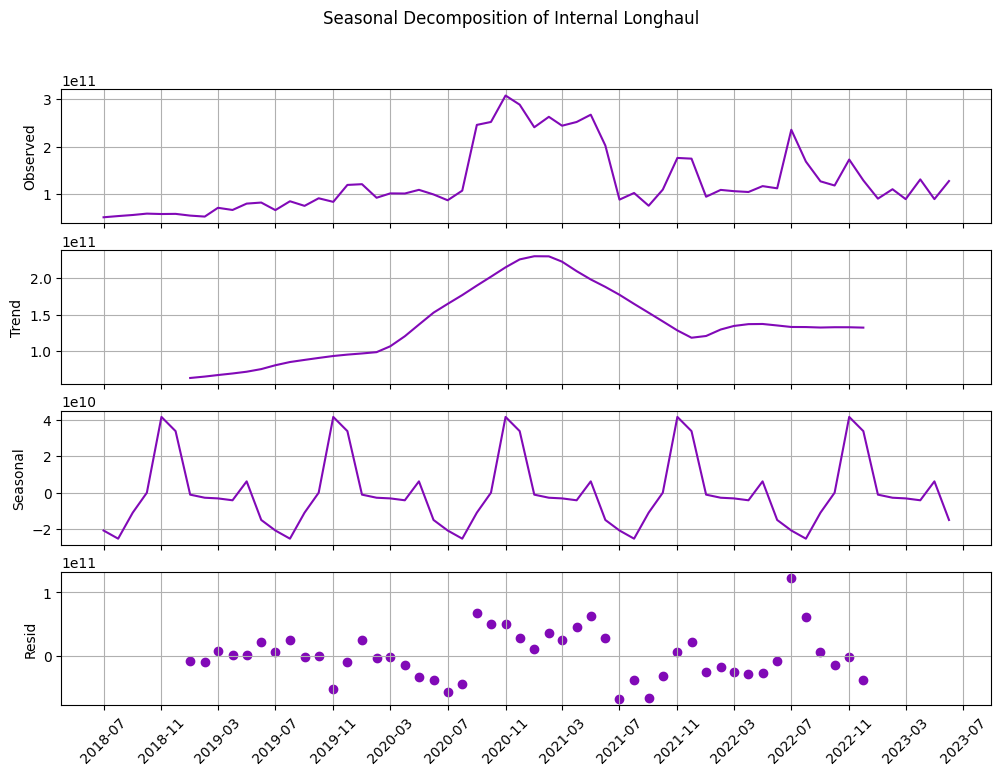

In [102]:
# Example for one of the time series; we can see the increase during covid
stl(pd.DataFrame(pivot_selected_df.reset_index()[['month', 'month_chart',tx_sys]]).rename(columns={tx_sys:'traffic'}), model='additive', title='Seasonal Decomposition of Internal Longhaul', color=color_longhaul);

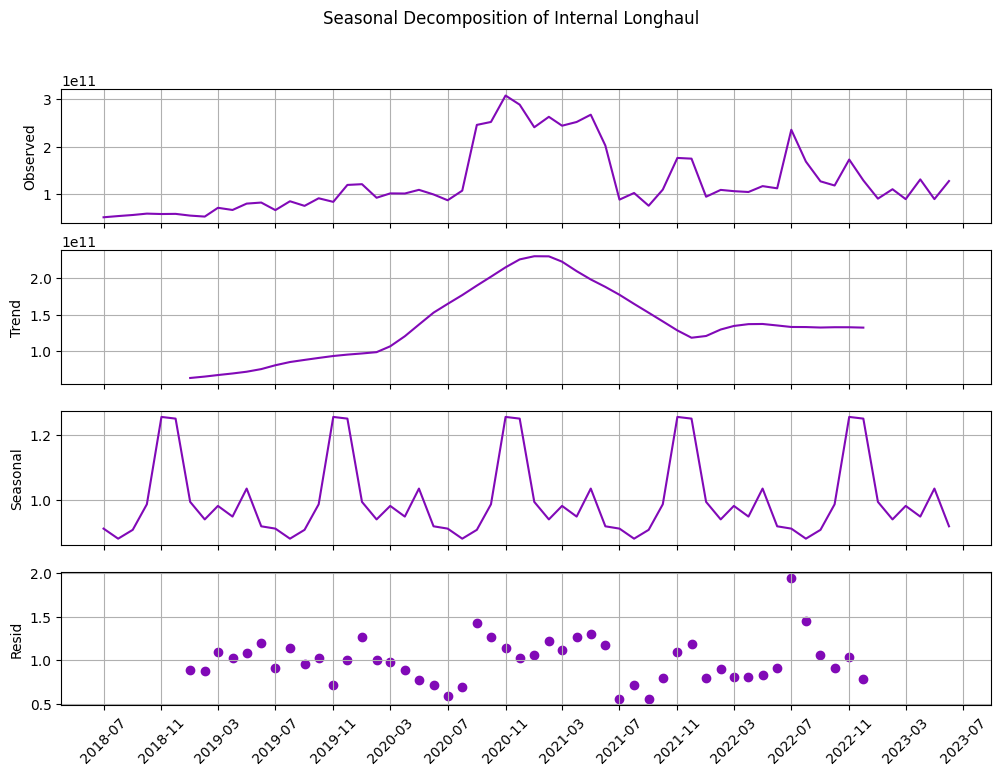

In [103]:
stl(pd.DataFrame(pivot_selected_df.reset_index()[['month', 'month_chart',tx_sys]]).rename(columns={tx_sys:'traffic'}), model='multiplicative', title='Seasonal Decomposition of Internal Longhaul', color=color_longhaul);

###### Holt Winters Forecasting 

In [104]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# def hwmodel(tx_sys):
#     return ExponentialSmoothing(selected_train[tx_sys], trend='add', seasonal='mul', seasonal_periods=12).fit()

def hwmodel(tx_sys):
    clean_train = selected_train[tx_sys].dropna()
    clean_train = clean_train[clean_train > 0]
    return ExponentialSmoothing(clean_train, trend='add', seasonal='mul', seasonal_periods=12).fit()

In [105]:
# clean_train = selected_train['50086CGWP'].dropna()
# clean_train = clean_train[clean_train > 0]
# clean_train

In [106]:
hw_fit = hwmodel(tx_sys)

C:\Users\diane\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [107]:
hw_pred = hw_fit.forecast(12)
hw_pred

48    7.549692e+10
49    9.318021e+10
50    1.134026e+11
51    1.331216e+11
52    1.663733e+11
53    1.844192e+11
54    1.493646e+11
55    1.396555e+11
56    1.534839e+11
57    1.515956e+11
58    1.680714e+11
59    1.482665e+11
dtype: float64

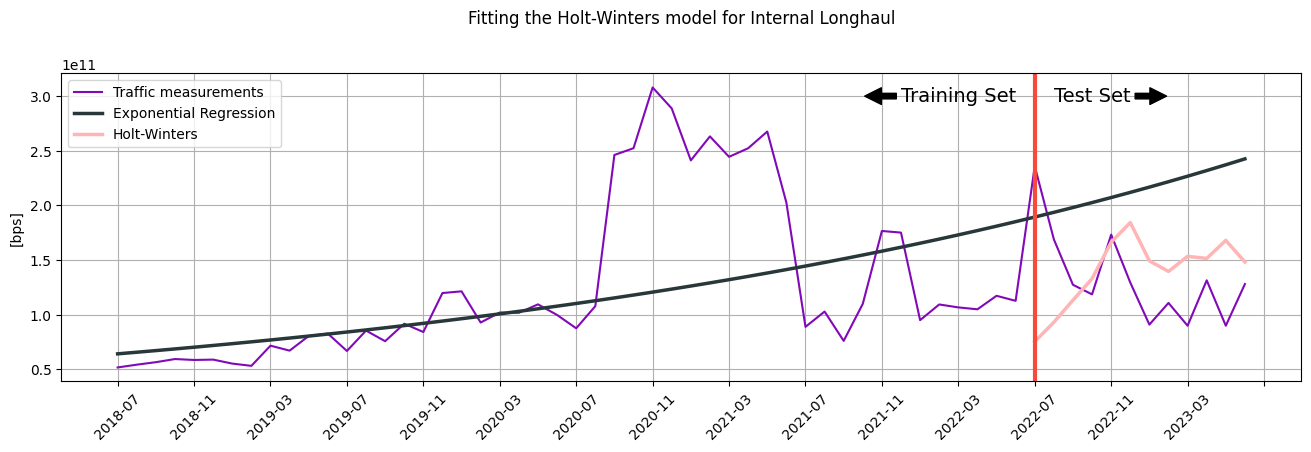

In [108]:
plt.figure(figsize=(16,4))

df_longhaul = pd.concat([selected_train, selected_test])
plt.plot(df_longhaul.month_chart, df_longhaul[tx_sys], color=color_longhaul, label='Traffic measurements')
plt.plot(LH_regexp_fit.month_chart, LH_regexp_fit.traffic, color=color_exp_reg, label='Exponential Regression', linewidth=2.5)
plt.plot(selected_test.month_chart, hw_pred, color=color_holt_winters, label='Holt-Winters', linewidth=2.5)

plt.axvline(x='2022-07' , color=color_timeline_devider, linewidth=3)

plt.annotate('Training Set', xy=(39,300000000000), xytext=(41,  295000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.annotate('Test Set', xy=(55,300000000000), xytext=(49, 295000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.ylabel('[bps]')
plt.title("Fitting the Holt-Winters model for Internal Longhaul\n\n")
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)
plt.grid()
plt.show()


### 4.2.3 Individual Link Insight - 'WAWT-424'

##### Decomposition 

In [109]:
## International
tx_sys = 'WAWT-424'

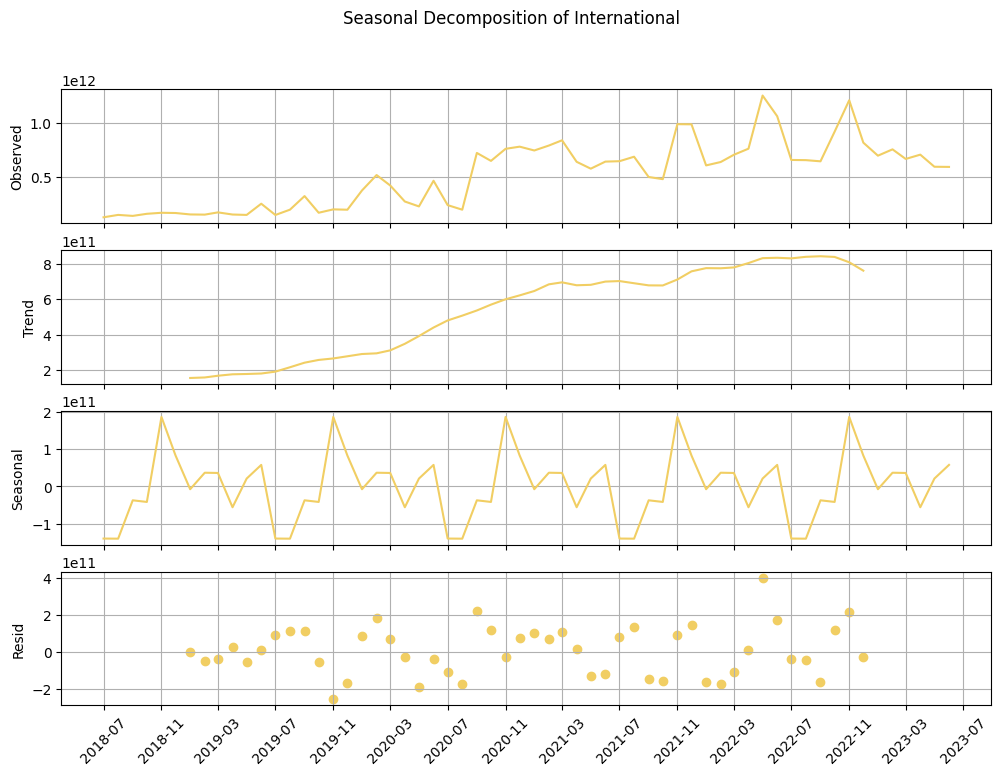

In [110]:
stl(pd.DataFrame(pivot_selected_df.reset_index()[['month', 'month_chart',tx_sys]]).rename(columns={tx_sys:'traffic'}), model='additive', title='Seasonal Decomposition of International', color=color_intl);

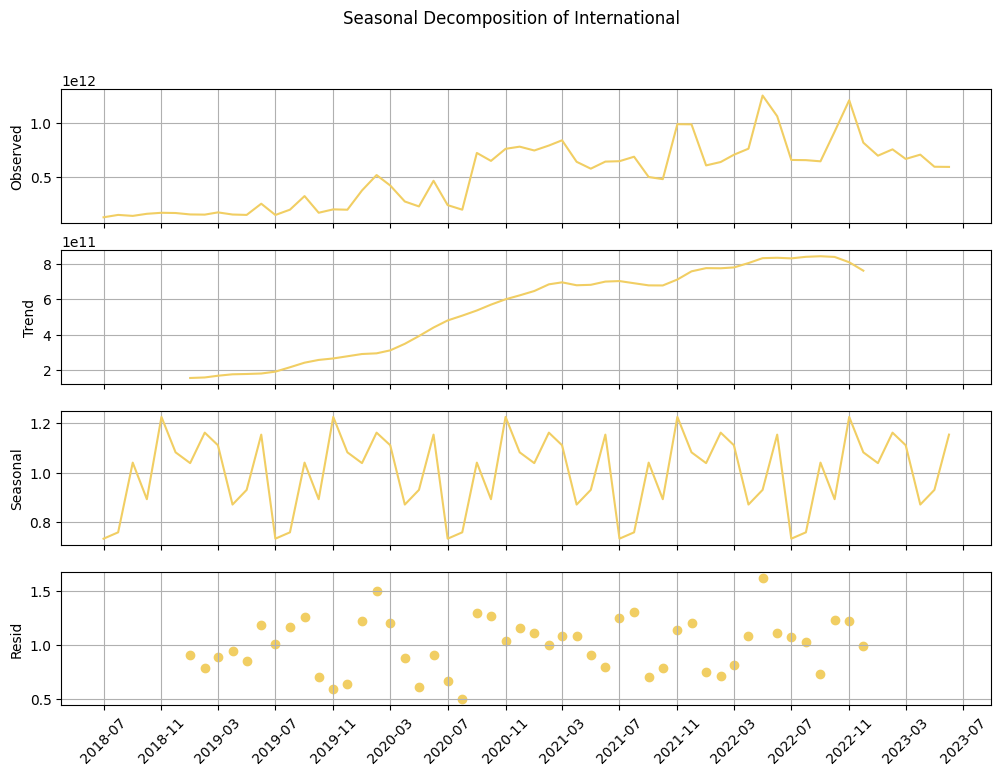

In [111]:
stl(pd.DataFrame(pivot_selected_df.reset_index()[['month', 'month_chart',tx_sys]]).rename(columns={tx_sys:'traffic'}), model='multiplicative', title='Seasonal Decomposition of International', color=color_intl);

###### Holt Winters Forecasting 

In [112]:
hw_fit = hwmodel(tx_sys)
hw_pred = hw_fit.forecast(12)
hw_pred

C:\Users\diane\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


48    7.001378e+11
49    7.451146e+11
50    1.134157e+12
51    8.345171e+11
52    1.158054e+12
53    1.121092e+12
54    1.175117e+12
55    1.345675e+12
56    1.258258e+12
57    9.117930e+11
58    8.011772e+11
59    1.222746e+12
dtype: float64

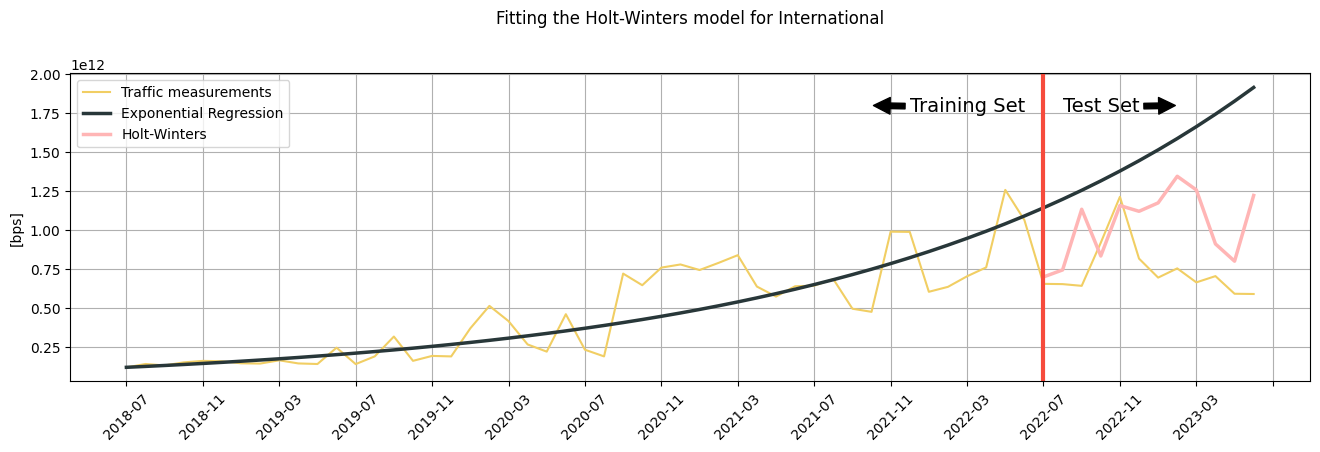

In [113]:
plt.figure(figsize=(16,4))

df_intl = pd.concat([selected_train, selected_test])
plt.plot(df_intl.month_chart, df_intl[tx_sys], color=color_intl, label='Traffic measurements')
plt.plot(inter_regexp_fit.month_chart, inter_regexp_fit.traffic, color=color_exp_reg, label='Exponential Regression', linewidth=2.5)
plt.plot(selected_test.month_chart, hw_pred, color=color_holt_winters, label='Holt-Winters', linewidth=2.5)

plt.axvline(x='2022-07' , color=color_timeline_devider, linewidth=3)

plt.annotate('Training Set', xy=(39,1800000000000), xytext=(41,  1760000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.annotate('Test Set', xy=(55,1800000000000), xytext=(49, 1760000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.ylabel('[bps]')
plt.title("Fitting the Holt-Winters model for International\n\n")
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)
plt.grid()
plt.show()

### 4.2.4 Individual Link Insight - 'CGSO-4754'

##### Decomposition 

In [114]:
## metro
tx_sys = 'CGSO-4754'

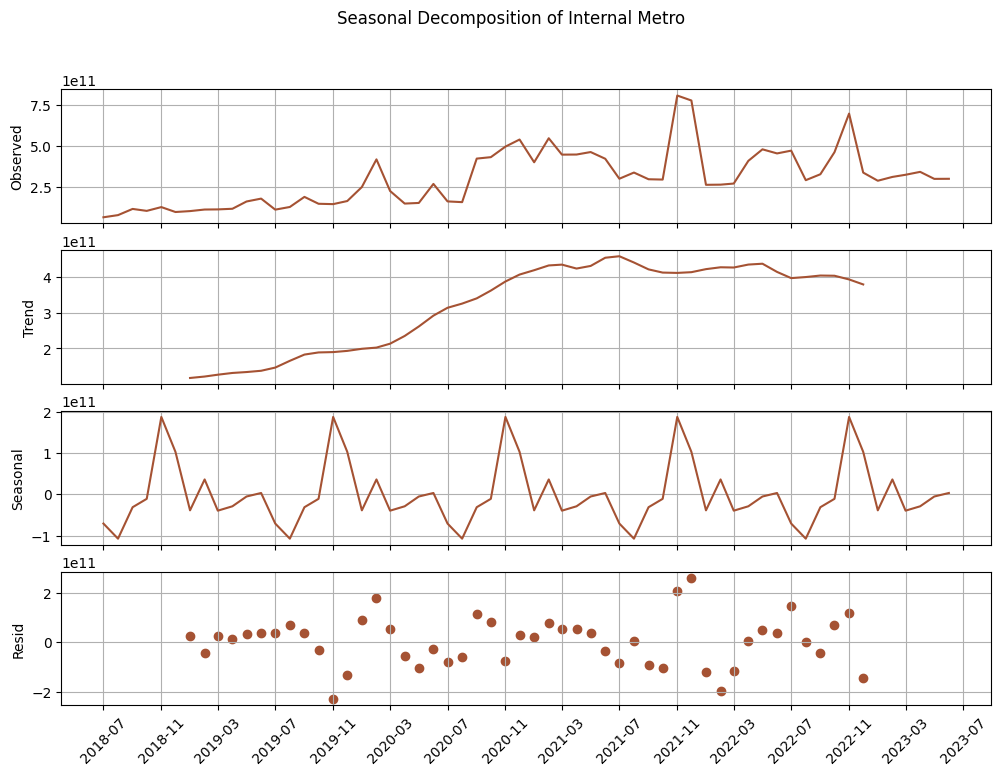

In [115]:
stl(pd.DataFrame(pivot_selected_df.reset_index()[['month', 'month_chart',tx_sys]]).rename(columns={tx_sys:'traffic'}), model='additive', title='Seasonal Decomposition of Internal Metro', color=color_metro);

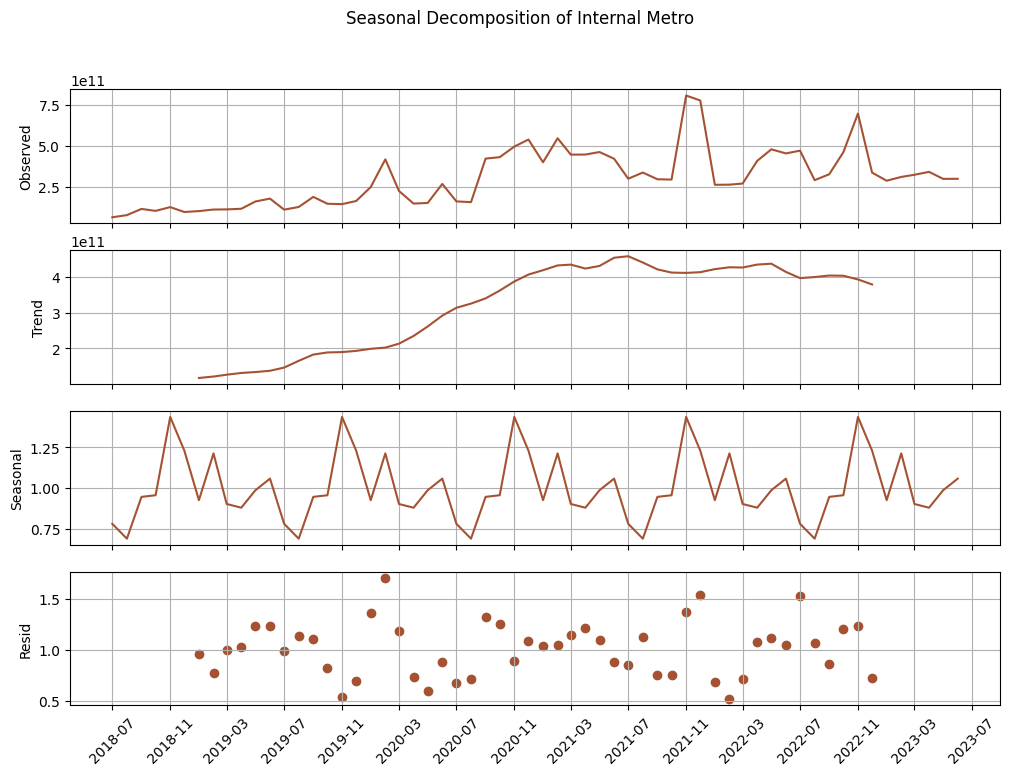

In [116]:
stl(pd.DataFrame(pivot_selected_df.reset_index()[['month', 'month_chart',tx_sys]]).rename(columns={tx_sys:'traffic'}), model='multiplicative', title='Seasonal Decomposition of Internal Metro', color=color_metro);

##### Holt Winters Forecasting

In [117]:
hw_fit = hwmodel(tx_sys)
hw_pred = hw_fit.forecast(12)
hw_pred

C:\Users\diane\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


48    2.858433e+11
49    3.042299e+11
50    4.547183e+11
51    4.171433e+11
52    6.308823e+11
53    6.486286e+11
54    5.028044e+11
55    7.029282e+11
56    5.009920e+11
57    4.410919e+11
58    4.958908e+11
59    5.536484e+11
dtype: float64

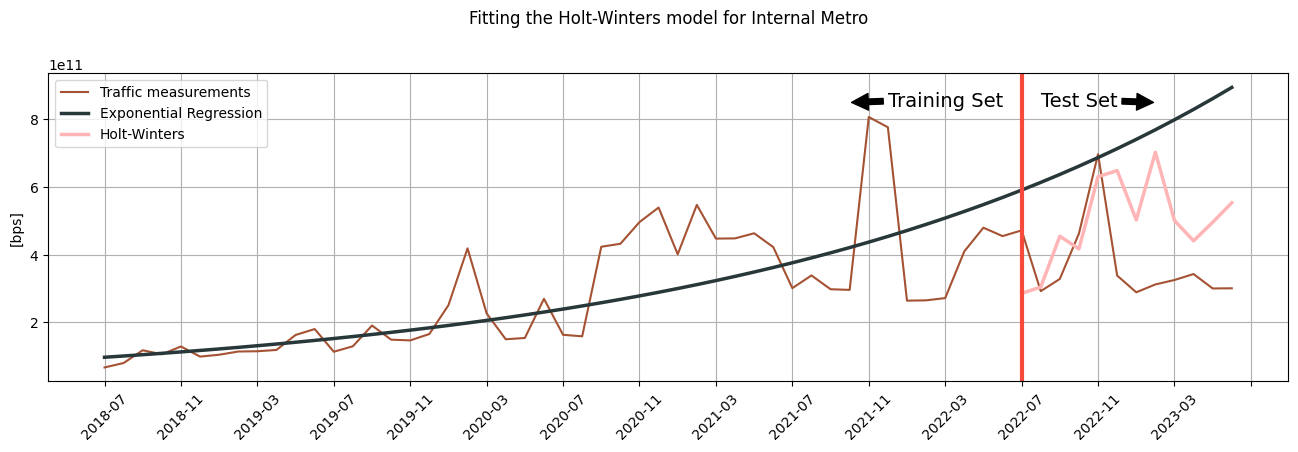

In [118]:
plt.figure(figsize=(16,4))

df_metro = pd.concat([selected_train, selected_test])
plt.plot(df_metro.month_chart, df_metro[tx_sys], color=color_metro, label='Traffic measurements')
plt.plot(metro_regexp_fit.month_chart, metro_regexp_fit.traffic, color=color_exp_reg, label='Exponential Regression', linewidth=2.5)
plt.plot(selected_test.month_chart, hw_pred, color=color_holt_winters, label='Holt-Winters', linewidth=2.5)

plt.axvline(x='2022-07' , color=color_timeline_devider, linewidth=3)

plt.annotate('Training Set', xy=(39,850000000000), xytext=(41,  838000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.annotate('Test Set', xy=(55,850000000000), xytext=(49, 838000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.ylabel('[bps]')
plt.title("Fitting the Holt-Winters model for Internal Metro\n\n")
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)
plt.grid()
plt.show()

## 4.3 Apply Hot Winters Forecasting to the Entire Set of Links

In [119]:
def error(test, pred):
    MAPE = mean_absolute_percentage_error(test, pred)
    RMSE = np.sqrt(mean_squared_error(test, pred))
    return MAPE, RMSE

def meanvar(ser):
    ser_mean, ser_var = ser.mean(), np.sqrt(ser.var())
    return ser_mean, ser_var

In [120]:
HW_Predictions = pd.DataFrame()
HW_Predictions['month'] = selected_test.month
HW_Predictions['month_chart'] = selected_test.month_chart

HW_Errors = []

for col in selected_train.columns:
    if col not in ['month', 'month_chart']:
        hw_fit = hwmodel(col)
        hw_pred = hw_fit.forecast(12)
        HW_Predictions[col] = hw_pred
        
        testset = pd.DataFrame(selected_test[col]).dropna()
        testset = testset[testset > 0]
        
        clean_pred = hw_pred.dropna()
        testset = testset[testset.index.isin(clean_pred.index)].dropna()
        clean_pred = clean_pred[clean_pred.index.isin(testset.index)]
        
        errors = error(testset, clean_pred)
        meanstd = meanvar(selected_train[col].dropna())
        #print(selected_train[col])
        HW_Errors.append(dict(name=col, mean=meanstd[0], std=meanstd[1], RMSE=errors[1], MAPE=errors[0]))

#HW_Predictions
                 
HW_Errors = pd.DataFrame(HW_Errors).set_index('name').T
HW_Errors
#HW_Errors.loc['RMSE']
#HW_Errors.mean(axis=1)
# how come MAPE are so high???

C:\Users\diane\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\diane\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\diane\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\diane\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\diane\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retval

name,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,EDAR-2222,EDWE-1221,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
mean,1.258880e+11,1.727240e+11,1.991722e+11,4.341787e+11,8.405238e+10,7.715855e+10,2.847233e+11,7.588269e+10,9.726764e+10,4.386653e+10,...,1.200631e+11,1.899311e+11,4.619424e+11,2.941872e+11,3.503160e+11,5.775048e+11,7.229241e+10,1.198935e+11,7.219870e+10,1.164164e+11
std,7.365458e+10,8.423324e+10,1.242000e+11,1.452238e+11,6.029855e+10,4.382050e+10,1.783218e+11,1.597463e+10,4.914090e+10,7.542349e+09,...,5.094905e+10,7.188075e+10,3.042121e+11,1.277537e+11,1.552732e+11,2.361118e+11,4.786775e+10,5.640034e+10,3.536716e+10,9.095158e+10
RMSE,6.462668e+10,6.057766e+10,4.653891e+10,8.891253e+10,2.349671e+10,3.854665e+10,2.029962e+11,2.422222e+10,4.416489e+10,1.253133e+10,...,1.056628e+11,4.566201e+10,3.840975e+11,8.612623e+10,1.168417e+11,1.207266e+11,4.767855e+10,3.996068e+10,1.756867e+10,5.676110e+10
MAPE,3.838701e-01,3.739837e-01,1.086397e-01,1.125214e-01,8.553569e+03,4.688148e-01,5.199060e-01,2.230383e-01,1.718515e-01,1.605793e-01,...,4.257201e-01,1.404105e-01,4.633237e-01,1.756629e-01,1.692824e-01,1.117961e-01,2.363704e-01,1.450988e-01,1.322168e-01,5.887979e-01


In [121]:
# mape mean doesn't seem right
HW_Errors.median(axis=1)

mean    1.181549e+11
std     5.853838e+10
RMSE    4.710873e+10
MAPE    2.549307e-01
dtype: float64

## 4.4 SEASONAL ARIMA

### Recall Selected Dataset

In [122]:
selected_train.tail()

base_doc_id,month,month_chart,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
43,2022-02-01,2022-02,1.094644e+11,1.955219e+11,3.428532e+11,5.434341e+11,3.777130e+09,9.007793e+10,2.651847e+11,7.714872e+10,...,1.244065e+11,3.196982e+11,6.365160e+11,3.361554e+11,4.559926e+11,7.029205e+11,1.306556e+11,2.772641e+11,1.178040e+11,1.015674e+11
44,2022-03-01,2022-03,1.067831e+11,1.538324e+11,4.005449e+11,5.882993e+11,2.451558e+10,1.041370e+11,2.718599e+11,8.121142e+10,...,1.177773e+11,2.932221e+11,7.042927e+11,3.935169e+11,5.249527e+11,8.120312e+11,9.957186e+10,2.124884e+11,1.009107e+11,8.595268e+10
45,2022-04-01,2022-04,1.050370e+11,1.348699e+11,3.440764e+11,5.146199e+11,5.511224e+09,8.712460e+10,4.098909e+11,7.757980e+10,...,8.320670e+10,2.908942e+11,7.611789e+11,3.858302e+11,4.361448e+11,6.998507e+11,1.042629e+11,2.144121e+11,1.135691e+11,7.809764e+10
46,2022-05-01,2022-05,1.173928e+11,NaN,2.898055e+11,5.599091e+11,8.741850e+09,9.473341e+10,4.799529e+11,9.702223e+10,...,2.329749e+11,2.816820e+11,1.258350e+12,4.753187e+11,4.430626e+11,8.055081e+11,1.078324e+11,1.849302e+11,1.069035e+11,1.026932e+11
47,2022-06-01,2022-06,1.127865e+11,NaN,3.421285e+11,5.646369e+11,8.879094e+09,8.789628e+10,4.550539e+11,9.720055e+10,...,9.699434e+10,2.832713e+11,1.065028e+12,4.359406e+11,4.676471e+11,8.586714e+11,1.188061e+11,1.782643e+11,1.030478e+11,1.293223e+11


In [124]:
selected_test.head()

base_doc_id,month,month_chart,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
48,2022-07-01,2022-07,2.359298e+11,NaN,3.512250e+11,4.905041e+11,4.832280e+09,9.200168e+10,4.719670e+11,9.372068e+10,...,1.479241e+11,3.399088e+11,6.557246e+11,4.351509e+11,4.680600e+11,7.328269e+11,2.057247e+11,2.244710e+11,1.050094e+11,1.405439e+11
49,2022-08-01,2022-08,1.690390e+11,9.931481e+10,2.705777e+11,5.776366e+11,5.031674e+09,1.088809e+11,2.923694e+11,1.048936e+11,...,9.211775e+10,2.974428e+11,6.540106e+11,4.402238e+11,4.423126e+11,8.608377e+11,1.232141e+11,1.925457e+11,1.039473e+11,8.725133e+10
50,2022-09-01,2022-09,1.274603e+11,1.465655e+11,3.110178e+11,6.000476e+11,5.943855e+09,1.073582e+11,3.284571e+11,1.543013e+11,...,1.042891e+11,3.192972e+11,6.429840e+11,4.681840e+11,5.086166e+11,9.069184e+11,1.413312e+11,1.988873e+11,1.076326e+11,9.939650e+10
51,2022-10-01,2022-10,1.187038e+11,1.424533e+11,3.485812e+11,6.755189e+11,1.074823e+10,9.960804e+10,4.626018e+11,7.756259e+10,...,3.947843e+11,3.568488e+11,9.200591e+11,4.191267e+11,5.265644e+11,9.686580e+11,1.429193e+11,2.080698e+11,1.237984e+11,7.292173e+10
52,2022-11-01,2022-11,1.733298e+11,1.827615e+11,3.965647e+11,6.605556e+11,7.185098e+09,7.974391e+10,6.972275e+11,1.027221e+11,...,2.497086e+11,3.060902e+11,1.214031e+12,5.504575e+11,5.079935e+11,9.633737e+11,1.348736e+11,2.450051e+11,1.227351e+11,7.830284e+10


### 4.4.1 Stationarity

##### Strationarity Test

In [125]:
# To apply ARIMA, we first need to confirm the time series is stationary with Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def adfFnc(ser):
    clean_train = ser.dropna()
    clean_train = clean_train[clean_train > 0]
    return adfuller(clean_train)[1]

In [126]:
for col in selected_train.columns[2:]:
    pvalue = adfFnc(selected_train[col])
    if pvalue <= 0.05:
        print(col, pvalue)

ILEC-405 4.302727038865338e-11
OKHT-970 4.019382541246271e-10
RDHE-341 0.005417030749284966
SSHA-975 4.277499738668396e-06
WPSC-1733 1.0161433582809713e-05


##### Make a non-stationary timeseries stationary (i.e. mean, variance and auto-correlation are constant over time) if needed

In [127]:
# mean - differentiate the serie
def diffSer(ser, freq=1):
    clean_train = ser.dropna()
    clean_train = clean_train[clean_train > 0]
    
    if freq==1:
        return clean_train.diff()
    
    # seasonal differentiate
    else:
        return clean_train.diff(periods=freq)

In [128]:
# variance
# df1 = np.log(df)
#df2.plot()

In [ ]:
# ser.diff()
# ser.diff(periods=12)

In [129]:
def station_ts(tx_sys):
    pvalue = adfFnc(selected_train[tx_sys])
    if pvalue > 0.05:
        pvalue = adfFnc(diffSer(selected_train[tx_sys]))
        if pvalue > 0.05:
            pvalue = adfFnc(diffSer(selected_train[tx_sys], 12))
    return pvalue

In [130]:
for col in selected_train.columns[2:]:
    optimized_pvalue = station_ts(col)
    if optimized_pvalue >= 0.05:
        print(col, optimized_pvalue)

EDAR-2222 0.4309558555056509
EDWE-1221 0.08290536080637984
ILEC-376 0.7799276889679869
WPNR-2009 0.2977270136761026


### 4.4.2 AUTO-ARIMA 

In [132]:
import pmdarima as pm

def arima_model(tx_sys):
    clean_train = selected_train[['month', 'month_chart', tx_sys]].rename(columns={tx_sys:'traffic'}).dropna()
    clean_train = clean_train[clean_train['traffic'] > 0]
    
    return pm.auto_arima(clean_train.set_index('month_chart')[['traffic']], 
                        start_p=1, 
                        start_q=1,
                        test='adf', 
                        max_p=3, 
                        max_q=3, 
                        m=12, 
                        start_P=0, 
                        seasonal=True,        
                        d=None, 
                        D=1, 
                        trace=False, 
                        error_action='ignore',
                        suppress_warnings=True, 
                        stepwise=True)

In [133]:
# import pmdarima as pm

def arima_model2(tx_sys):
    clean_train = selected_train[['month', 'month_chart', tx_sys]].rename(columns={tx_sys:'traffic'}).dropna()
    clean_train = clean_train[clean_train['traffic'] > 0]
    
    return pm.auto_arima(clean_train.set_index('month_chart')[['traffic']], 
                        start_p=1, 
                        start_q=1,
                        test='adf', 
                        max_p=5, 
                        max_q=5, 
                        m=12, 
                        start_P=1, 
                        start_Q=1,
                        max_P=5, 
                        max_Q=5,
                        seasonal=True,        
                        d=None, 
                        D=1, 
                        max_D = 2,
                        max_order = 12,
                        trace=False, 
                        error_action='ignore',
                        suppress_warnings=True, 
                        stepwise=True)

In [134]:
tx_sys = '50086CGWP'
LH_sarima2 = arima_model2(tx_sys)
LH_sarima_pred2 = LH_sarima2.predict(n_periods=12, return_conf_int=True)[0]
LH_sarima_pred2

2022-07-01    6.395252e+10
2022-08-01    7.821831e+10
2022-09-01    1.593993e+11
2022-10-01    1.705256e+11
2022-11-01    2.256918e+11
2022-12-01    2.082392e+11
2023-01-01    1.462792e+11
2023-02-01    1.618153e+11
2023-03-01    1.443195e+11
2023-04-01    1.451061e+11
2023-05-01    1.554894e+11
2023-06-01    1.060130e+11
Freq: MS, dtype: float64

In [136]:
LH_sarima_pred2.values

array([6.39525177e+10, 7.82183104e+10, 1.59399273e+11, 1.70525601e+11,
       2.25691784e+11, 2.08239211e+11, 1.46279176e+11, 1.61815315e+11,
       1.44319545e+11, 1.45106087e+11, 1.55489388e+11, 1.06013010e+11])

##### Internal LH - '50086CGWP'

In [137]:
tx_sys = '50086CGWP'

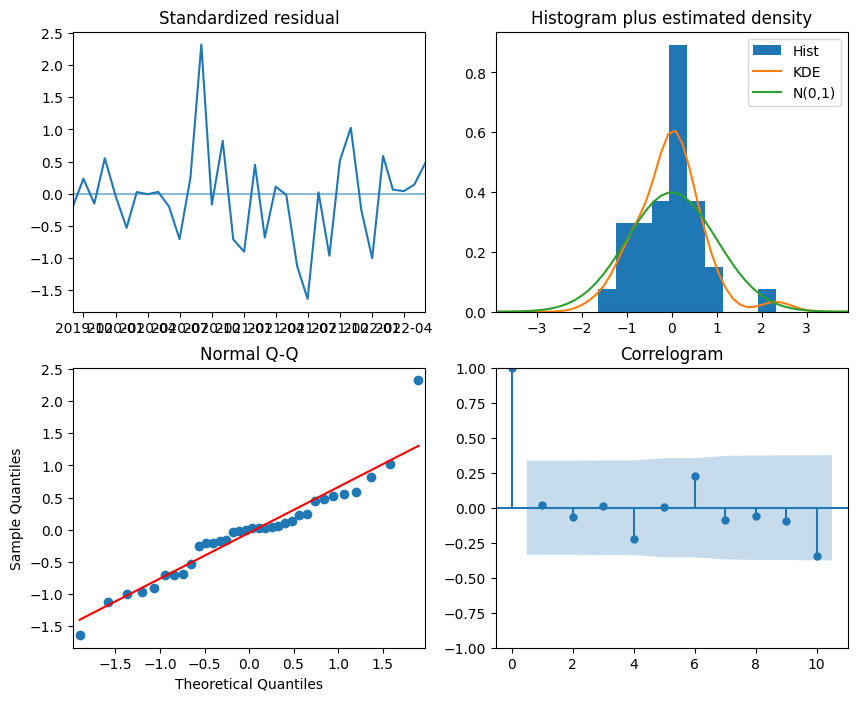

In [138]:
LH_sarima = arima_model(tx_sys)
LH_sarima.plot_diagnostics(figsize=(10, 8));

In [139]:
# test

In [140]:
LH_sarima_pred = LH_sarima.predict(n_periods=12, return_conf_int=True)[0]
LH_sarima_pred

2022-07-01    6.395252e+10
2022-08-01    7.821831e+10
2022-09-01    1.593993e+11
2022-10-01    1.705256e+11
2022-11-01    2.256918e+11
2022-12-01    2.082392e+11
2023-01-01    1.462792e+11
2023-02-01    1.618153e+11
2023-03-01    1.443195e+11
2023-04-01    1.451061e+11
2023-05-01    1.554894e+11
2023-06-01    1.060130e+11
Freq: MS, dtype: float64

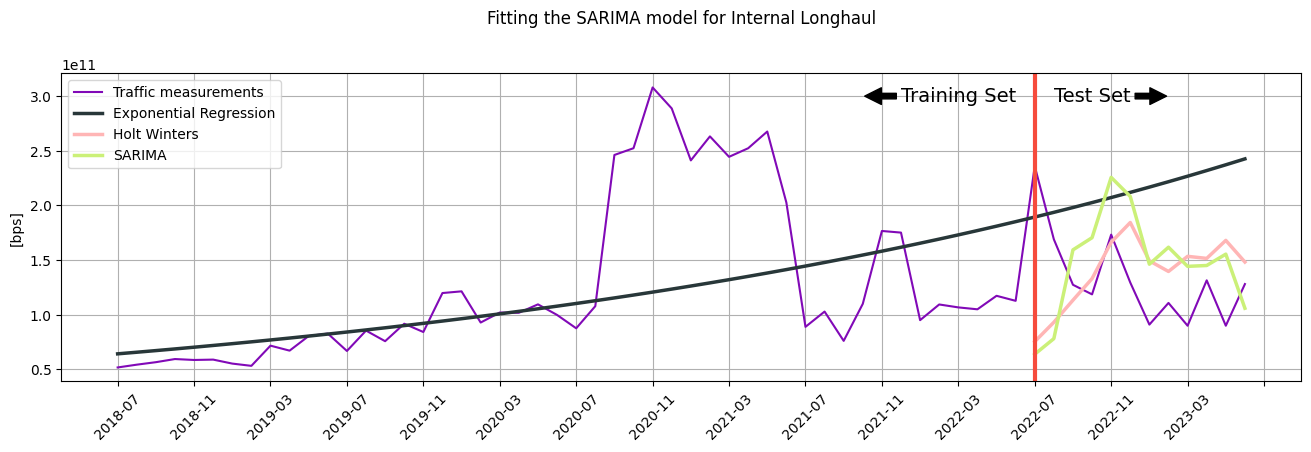

In [141]:
plt.figure(figsize=(16,4))

df_traffic = pd.concat([selected_train, selected_test])

plt.plot(df_traffic.month_chart, df_traffic[tx_sys], color=color_longhaul, label='Traffic measurements')
plt.plot(LH_regexp_fit.month_chart, LH_regexp_fit.traffic, color=color_exp_reg, label='Exponential Regression', linewidth=2.5)
plt.plot(HW_Predictions.month_chart, HW_Predictions[tx_sys], color=color_holt_winters, label='Holt Winters', linewidth=2.5)
plt.plot(selected_test.month_chart, LH_sarima_pred, color=color_sarima, label='SARIMA', linewidth=2.5)
# plt.plot(selected_test.month_chart, test, color='b')

plt.axvline(x='2022-07' , color=color_timeline_devider, linewidth=3)

plt.annotate('Training Set', xy=(39,300000000000), xytext=(41,  295000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.annotate('Test Set', xy=(55,300000000000), xytext=(49, 295000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.ylabel('[bps]')
plt.title("Fitting the SARIMA model for Internal Longhaul\n\n")
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)
plt.grid()
plt.show()

##### International - 'WAWT-424'

In [142]:
tx_sys = 'WAWT-424'

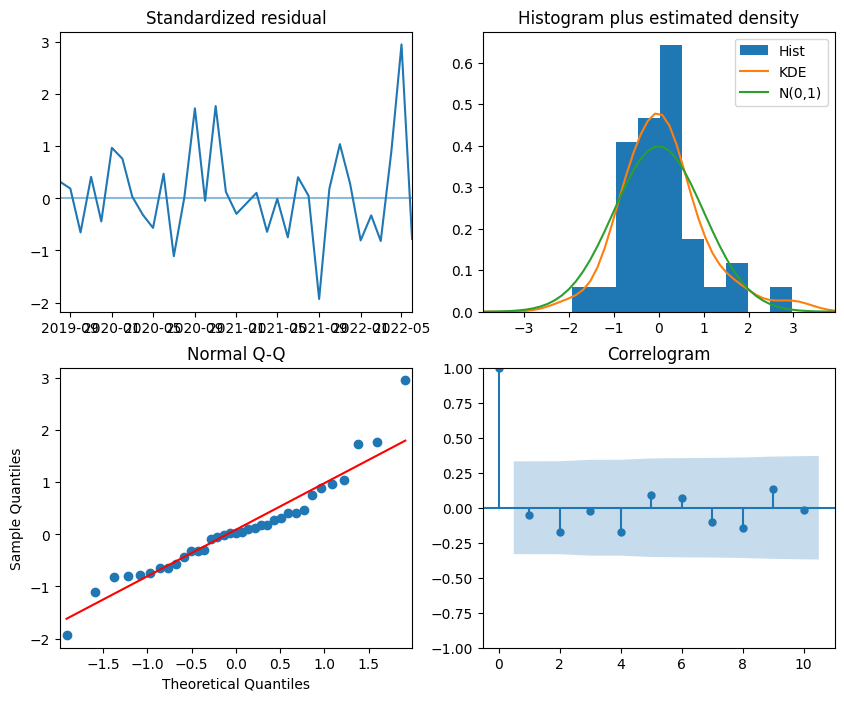

In [143]:
inter_sarima = arima_model(tx_sys)
inter_sarima.plot_diagnostics(figsize=(10, 8));

In [144]:
inter_sarima_pred = inter_sarima.predict(n_periods=12, return_conf_int=True)[0]
inter_sarima_pred

2022-07-01    7.326769e+11
2022-08-01    9.402417e+11
2022-09-01    1.146814e+12
2022-10-01    9.807512e+11
2022-11-01    1.166513e+12
2022-12-01    1.240842e+12
2023-01-01    1.125875e+12
2023-02-01    1.130892e+12
2023-03-01    1.146004e+12
2023-04-01    1.119052e+12
2023-05-01    1.310364e+12
2023-06-01    1.278803e+12
Freq: MS, dtype: float64

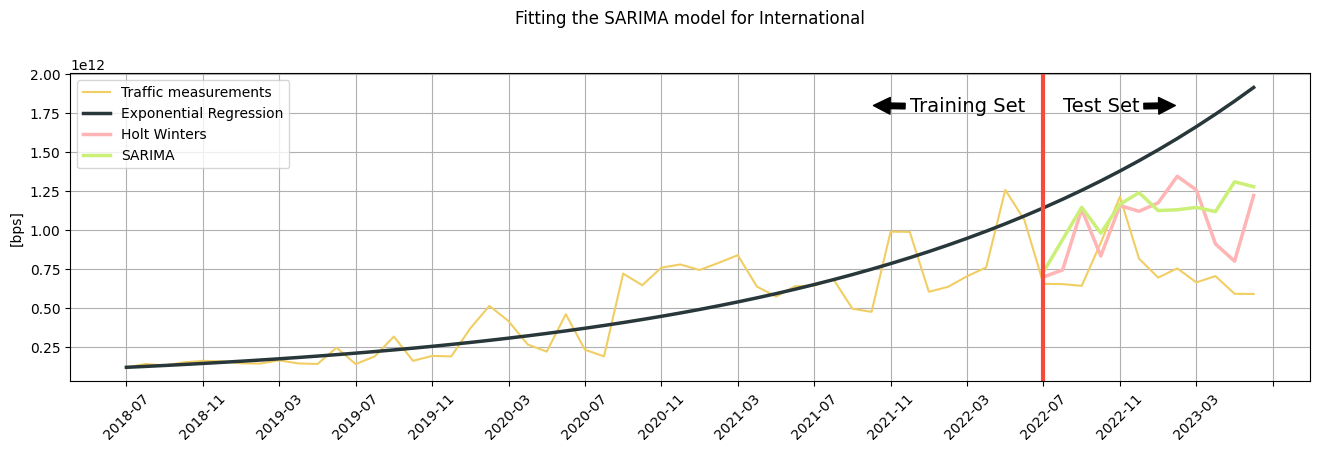

In [145]:
plt.figure(figsize=(16,4))

df_traffic = pd.concat([selected_train, selected_test])

plt.plot(df_traffic.month_chart, df_traffic[tx_sys], color=color_intl, label='Traffic measurements')
plt.plot(inter_regexp_fit.month_chart, inter_regexp_fit.traffic, color=color_exp_reg, label='Exponential Regression', linewidth=2.5)
plt.plot(HW_Predictions.month_chart, HW_Predictions[tx_sys], color=color_holt_winters, label='Holt Winters', linewidth=2.5)
plt.plot(selected_test.month_chart, inter_sarima_pred, color=color_sarima, label='SARIMA', linewidth=2.5)

plt.axvline(x='2022-07' , color=color_timeline_devider, linewidth=3)

plt.annotate('Training Set', xy=(39,1800000000000), xytext=(41,  1760000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.annotate('Test Set', xy=(55,1800000000000), xytext=(49, 1760000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.ylabel('[bps]')
plt.title("Fitting the SARIMA model for International\n\n")
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)
plt.grid()
plt.show()

##### Internal Metro Link - 'CGSO-4754'

In [146]:
tx_sys = 'CGSO-4754'

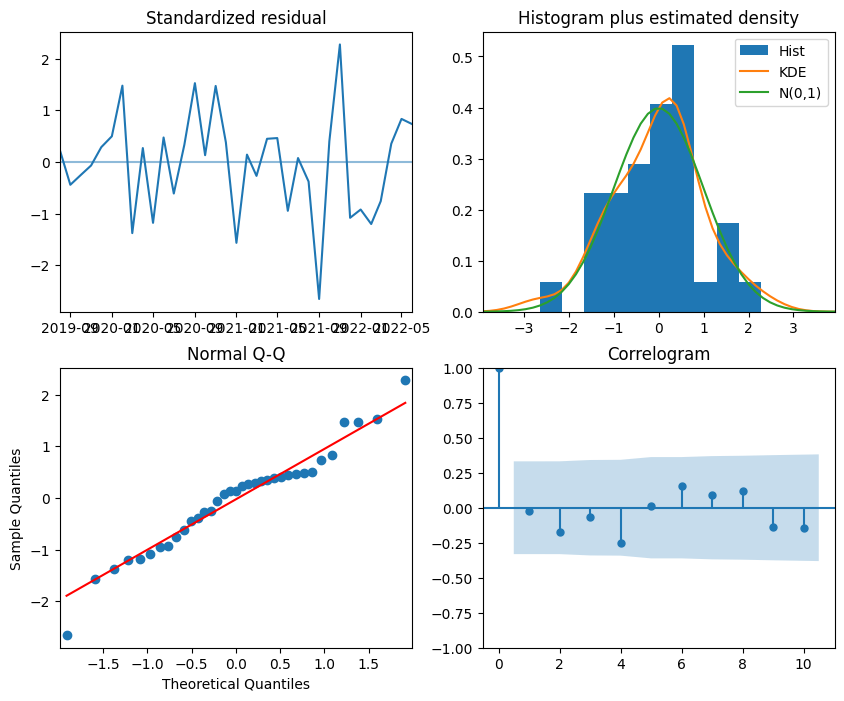

In [147]:
metro_sarima = arima_model(tx_sys)
metro_sarima.plot_diagnostics(figsize=(10, 8));

In [148]:
metro_sarima_pred = metro_sarima.predict(n_periods=12, return_conf_int=True)[0]
metro_sarima_pred

2022-07-01    3.039541e+11
2022-08-01    3.291352e+11
2022-09-01    3.038921e+11
2022-10-01    3.108157e+11
2022-11-01    8.138274e+11
2022-12-01    7.777086e+11
2023-01-01    2.689209e+11
2023-02-01    2.737313e+11
2023-03-01    2.786566e+11
2023-04-01    4.142995e+11
2023-05-01    4.850907e+11
2023-06-01    4.616394e+11
Freq: MS, dtype: float64

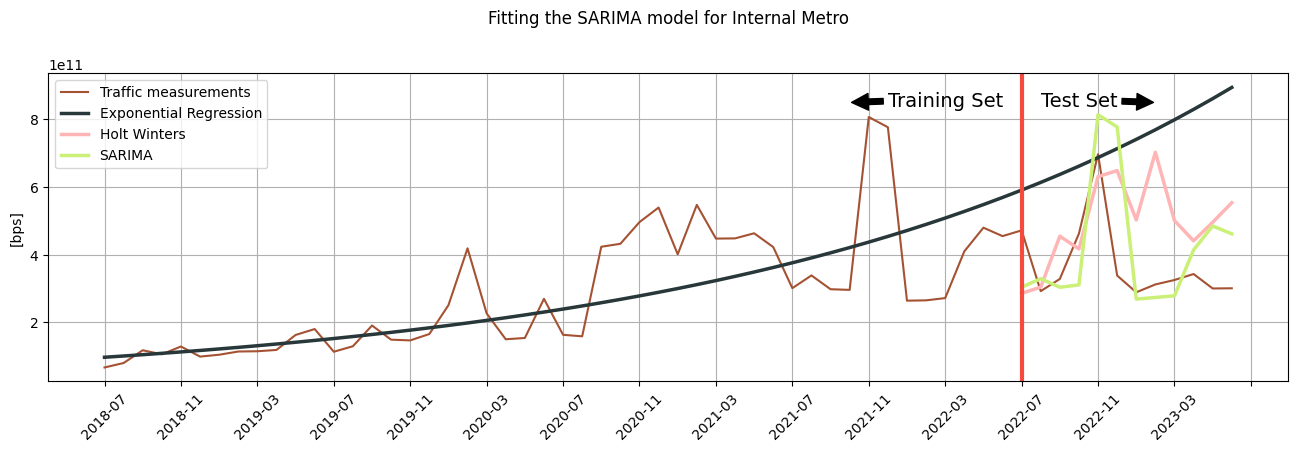

In [149]:
plt.figure(figsize=(16,4))

df_traffic = pd.concat([selected_train, selected_test])

plt.plot(df_traffic.month_chart, df_traffic[tx_sys], color=color_metro, label='Traffic measurements')
plt.plot(metro_regexp_fit.month_chart, metro_regexp_fit.traffic, color=color_exp_reg, label='Exponential Regression', linewidth=2.5)
plt.plot(HW_Predictions.month_chart, HW_Predictions[tx_sys], color=color_holt_winters, label='Holt Winters', linewidth=2.5)
plt.plot(selected_test.month_chart, metro_sarima_pred, color=color_sarima, label='SARIMA', linewidth=2.5)

plt.axvline(x='2022-07' , color=color_timeline_devider, linewidth=3)

plt.annotate('Training Set', xy=(39,850000000000), xytext=(41, 838000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.annotate('Test Set', xy=(55,850000000000), xytext=(49, 838000000000),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)

plt.ylabel('[bps]')
plt.title("Fitting the SARIMA model for Internal Metro\n\n")
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)
plt.grid()
plt.show()

### 4.4.2 APPLY SARIMA TO ALL LINKS

In [150]:
SARIMA_Predictions = pd.DataFrame()
SARIMA_Predictions['month'] = selected_test.month
SARIMA_Predictions['month_chart'] = selected_test.month_chart

SARIMA_Errors = []

for col in selected_train.columns:
    if col not in ['month', 'month_chart']:
        sarima_fit = arima_model(col)
        sarima_pred = sarima_fit.predict(n_periods=12, return_conf_int=True)[0]
        SARIMA_Predictions[col] = sarima_pred.values
        
        testset = pd.DataFrame(selected_test[col]).dropna()
        testset = testset[testset > 0]

        clean_pred = pd.DataFrame(sarima_pred.values, index=SARIMA_Predictions.index.copy())
        testset = testset[testset.index.isin(clean_pred.index)].dropna()
        clean_pred = clean_pred[clean_pred.index.isin(testset.index)]
        
        errors = error(testset, clean_pred)
        meanstd = meanvar(selected_train[col].dropna())
        SARIMA_Errors.append(dict(name=col, mean=meanstd[0], std=meanstd[1], RMSE=errors[1], MAPE=errors[0]))
        

SARIMA_Predictions        

# SARIMA_Errors = pd.DataFrame(SARIMA_Errors).set_index('name').T
# SARIMA_Errors

C:\Users\diane\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,month,month_chart,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
48,2022-07-01,2022-07,6.395252e+10,1.087084e+11,3.373256e+11,5.235202e+11,-4.533570e+10,6.419663e+10,3.039541e+11,1.027118e+11,...,1.259571e+11,2.698080e+11,7.326769e+11,3.930673e+11,4.990503e+11,8.282253e+11,1.046288e+11,1.955442e+11,1.004894e+11,4.856951e+10
49,2022-08-01,2022-08,7.821831e+10,1.418076e+11,3.515136e+11,5.319842e+11,-3.051392e+10,6.382150e+10,3.291352e+11,1.032340e+11,...,1.279377e+11,2.763933e+11,9.402417e+11,5.090389e+11,5.061244e+11,7.888113e+11,1.166956e+11,2.116145e+11,9.723491e+10,9.430811e+10
50,2022-09-01,2022-09,1.593993e+11,4.441843e+10,3.560663e+11,6.151339e+11,7.077196e+09,1.132022e+11,3.038921e+11,1.126890e+11,...,1.484626e+11,2.939834e+11,1.146814e+12,4.735491e+11,5.637581e+11,9.908490e+11,2.068944e+11,2.465843e+11,1.070769e+11,2.084620e+11
51,2022-10-01,2022-10,1.705256e+11,7.158487e+10,3.710708e+11,6.133682e+11,-1.748955e+10,9.941515e+10,3.108157e+11,1.123714e+11,...,1.652060e+11,3.255552e+11,9.807512e+11,4.082639e+11,5.318665e+11,1.081136e+12,1.433177e+11,2.451945e+11,1.086882e+11,7.298418e+10
52,2022-11-01,2022-11,2.256918e+11,2.500985e+11,4.180914e+11,6.251718e+11,1.975896e+10,1.444941e+11,8.138274e+11,1.222632e+11,...,1.285542e+11,3.671891e+11,1.166513e+12,8.472250e+11,6.082220e+11,1.039026e+12,1.673561e+11,4.030725e+11,1.208881e+11,1.996872e+11
53,2022-12-01,2022-12,2.082392e+11,1.817522e+11,4.022342e+11,6.341359e+11,7.286793e+09,1.331372e+11,7.777086e+11,1.173097e+11,...,1.640367e+11,3.504271e+11,1.240842e+12,7.638562e+11,6.685681e+11,1.017359e+12,2.166580e+11,4.110904e+11,1.189164e+11,7.791761e+10
54,2023-01-01,2023-01,1.462792e+11,1.878913e+11,3.853880e+11,6.285133e+11,-4.389220e+10,1.159482e+11,2.689209e+11,1.215331e+11,...,1.610625e+11,3.732153e+11,1.125875e+12,4.680041e+11,6.671676e+11,1.067466e+12,2.438714e+11,3.312107e+11,1.194662e+11,1.450275e+11
55,2023-02-01,2023-02,1.618153e+11,1.991307e+11,3.961636e+11,6.100603e+11,-2.114994e+10,1.194913e+11,2.737313e+11,1.188204e+11,...,1.713156e+11,3.817090e+11,1.130892e+12,4.335673e+11,6.791328e+11,9.953933e+11,1.411120e+11,3.999780e+11,1.237913e+11,4.719743e+10
56,2023-03-01,2023-03,1.443195e+11,1.961656e+11,4.308525e+11,6.666358e+11,-3.547302e+10,1.345223e+11,2.786566e+11,1.197524e+11,...,1.795558e+11,3.556388e+11,1.146004e+12,4.909288e+11,6.877485e+11,1.067213e+12,2.135799e+11,3.364552e+11,1.311278e+11,4.682819e+11
57,2023-04-01,2023-04,1.451061e+11,1.345609e+11,3.936697e+11,6.224829e+11,-3.971423e+10,1.282607e+11,4.142995e+11,1.152246e+11,...,1.238091e+11,3.535904e+11,1.119052e+12,4.832421e+11,5.689974e+11,1.034584e+12,1.739369e+11,3.397606e+11,1.303076e+11,2.028731e+11


In [151]:
SARIMA_Errors = pd.DataFrame(SARIMA_Errors).set_index('name').T
SARIMA_Errors

name,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,EDAR-2222,EDWE-1221,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
mean,1.258880e+11,1.727240e+11,1.991722e+11,4.341787e+11,8.405238e+10,7.715855e+10,2.847233e+11,7.588269e+10,9.726764e+10,4.386653e+10,...,1.200631e+11,1.899311e+11,4.619424e+11,2.941872e+11,3.503160e+11,5.775048e+11,7.229241e+10,1.198935e+11,7.219870e+10,1.164164e+11
std,7.365458e+10,8.423324e+10,1.242000e+11,1.452238e+11,6.029855e+10,4.382050e+10,1.783218e+11,1.597463e+10,4.914090e+10,7.542349e+09,...,5.094905e+10,7.188075e+10,3.042121e+11,1.277537e+11,1.552732e+11,2.361118e+11,4.786775e+10,5.640034e+10,3.536716e+10,9.095158e+10
RMSE,7.304434e+10,6.207813e+10,4.138890e+10,4.292684e+10,3.059210e+10,4.517667e+10,1.655618e+11,3.161903e+10,6.283838e+10,1.072543e+10,...,1.057147e+11,5.335514e+10,4.325020e+11,1.403006e+11,8.999779e+10,1.293473e+11,7.067130e+10,1.272734e+11,1.168013e+10,1.352913e+11
MAPE,4.613155e-01,3.580189e-01,1.117998e-01,5.909456e-02,5.989769e+03,5.282701e-01,3.369760e-01,3.257654e-01,2.903419e-01,1.228899e-01,...,4.417064e-01,1.611742e-01,5.637112e-01,1.988665e-01,1.539005e-01,1.322505e-01,4.719257e-01,5.420039e-01,8.631539e-02,1.130558e+00


In [152]:
SARIMA_Errors.loc['RMSE']
#SARIMA_Errors.mean(axis=1)
SARIMA_Errors.median(axis=1)

mean    1.181549e+11
std     5.853838e+10
RMSE    6.174385e+10
MAPE    3.313707e-01
dtype: float64

In [156]:
# mean_absolute_percentage_error(df_test.traffic, sarimaForecast(SARIMA_model)[0])

## 3.3 LSTM

In [160]:
selected_train.head()

base_doc_id,month,month_chart,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
0,2018-07-01,2018-07,5.185851e+10,6.212124e+10,4.235889e+10,1.818553e+11,3.898373e+10,5.331025e+10,6.682568e+10,4.668917e+10,...,4.985759e+10,9.037075e+10,1.194766e+11,1.336050e+11,1.876038e+11,2.221026e+11,1.547702e+10,6.664212e+10,3.641131e+10,5.110603e+10
1,2018-08-01,2018-08,5.440295e+10,7.060407e+10,1.274693e+11,2.203458e+11,3.910355e+10,2.935718e+10,7.997443e+10,5.778068e+10,...,5.961557e+10,1.034989e+11,1.417322e+11,1.561633e+11,1.987115e+11,2.572459e+11,2.792069e+10,6.289099e+10,2.712582e+10,1.347680e+11
2,2018-09-01,2018-09,5.667863e+10,9.924177e+10,4.053837e+10,2.287319e+11,3.678189e+10,2.929238e+10,1.176090e+11,6.456093e+10,...,6.347397e+10,9.825789e+10,1.324399e+11,1.582828e+11,2.082654e+11,2.635986e+11,2.278581e+10,7.009681e+10,1.919660e+10,5.910954e+10
3,2018-10-01,2018-10,5.955464e+10,8.740577e+10,9.375628e+10,2.503070e+11,3.573482e+10,3.034396e+10,1.057418e+11,6.611632e+10,...,6.238817e+10,1.021036e+11,1.520174e+11,1.981226e+11,1.995174e+11,3.006394e+11,2.413556e+10,7.555709e+10,2.615796e+10,1.051212e+11
4,2018-11-01,2018-11,5.870339e+10,9.524256e+10,5.367614e+10,2.451866e+11,3.582858e+10,3.036324e+10,1.287607e+11,6.495857e+10,...,8.345293e+10,1.075446e+11,1.615805e+11,1.778574e+11,1.951294e+11,2.735054e+11,2.257622e+10,8.823491e+10,2.948816e+10,6.622887e+10


In [161]:
selected_test.head()

base_doc_id,month,month_chart,50086CGWP,50090CGVC,50273CGWP,CGNO-4298,CGNO-4501,CGNO-4576,CGSO-4754,EDAR-1572,...,VCST-2125,WAWT-381,WAWT-424,WAWT-498,WAWT-540,WAWT-556,WPNR-2001,WPNR-2009,WPSC-1119,WPSC-1733
48,2022-07-01,2022-07,2.359298e+11,NaN,3.512250e+11,4.905041e+11,4.832280e+09,9.200168e+10,4.719670e+11,9.372068e+10,...,1.479241e+11,3.399088e+11,6.557246e+11,4.351509e+11,4.680600e+11,7.328269e+11,2.057247e+11,2.244710e+11,1.050094e+11,1.405439e+11
49,2022-08-01,2022-08,1.690390e+11,9.931481e+10,2.705777e+11,5.776366e+11,5.031674e+09,1.088809e+11,2.923694e+11,1.048936e+11,...,9.211775e+10,2.974428e+11,6.540106e+11,4.402238e+11,4.423126e+11,8.608377e+11,1.232141e+11,1.925457e+11,1.039473e+11,8.725133e+10
50,2022-09-01,2022-09,1.274603e+11,1.465655e+11,3.110178e+11,6.000476e+11,5.943855e+09,1.073582e+11,3.284571e+11,1.543013e+11,...,1.042891e+11,3.192972e+11,6.429840e+11,4.681840e+11,5.086166e+11,9.069184e+11,1.413312e+11,1.988873e+11,1.076326e+11,9.939650e+10
51,2022-10-01,2022-10,1.187038e+11,1.424533e+11,3.485812e+11,6.755189e+11,1.074823e+10,9.960804e+10,4.626018e+11,7.756259e+10,...,3.947843e+11,3.568488e+11,9.200591e+11,4.191267e+11,5.265644e+11,9.686580e+11,1.429193e+11,2.080698e+11,1.237984e+11,7.292173e+10
52,2022-11-01,2022-11,1.733298e+11,1.827615e+11,3.965647e+11,6.605556e+11,7.185098e+09,7.974391e+10,6.972275e+11,1.027221e+11,...,2.497086e+11,3.060902e+11,1.214031e+12,5.504575e+11,5.079935e+11,9.633737e+11,1.348736e+11,2.450051e+11,1.227351e+11,7.830284e+10


In [162]:
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense, LSTM, Dropout, Bidirectional

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

### Data Exploration

In [163]:
tx_sys_id = '50086CGWP'

ts_train = pd.DataFrame()
ts_train['month'] = selected_train.month
ts_train['traffic'] = selected_train[[tx_sys_id]]
ts_train = ts_train.set_index('month')

ts_test = pd.DataFrame()
ts_test['month'] = selected_test.month
ts_test['traffic'] = selected_test[[tx_sys_id]]
ts_test = ts_test.set_index('month')

ts_train.head(), ts_test.head()
ts_train.shape, ts_test.shape

((48, 1), (12, 1))

### Preprocessing (scaling)

In [166]:
scaler = MinMaxScaler()
scaled_ts_train = scaler.fit_transform(ts_train)
scaled_ts_test = scaler.transform(ts_test)

In [167]:
def data_sequence(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

window=12
trainX, trainY = data_sequence(scaled_ts_train, window)
testX, testY = data_sequence(scaled_ts_test, window)
trainX.shape, trainY.shape, testX.shape, testY.shape

((35, 12), (35,), (0,), (0,))

### Reshaping the data

In [168]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
trainX.shape

(35, 12, 1)

### Building the model

In [169]:
model = Sequential()
model.add(LSTM(4, activation='relu', input_shape=(window, 1), return_sequences=True))
model.add(LSTM(4, activation='relu', return_sequences=True))
model.add(LSTM(4, activation='sigmoid', return_sequences=False))
model.add(Dense(1))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

### 3.3.1 Data Preparation

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

def normalize_data(ts, test_split_value=6):
    ts_train = ts.iloc[:(ts.shape[0] - test_split_value)]
    ts_test = ts.iloc[(ts.shape[0] - test_split_value):]
#     print(ts_train.shape, ts_test.shape)
    
    scaler = MinMaxScaler()
    scaler.fit(ts_train)
    scaled_train = scaler.transform(ts_train)
    scaled_test = scaler.transform(ts_test)
    
    return pd.concat([pd.DataFrame(scaled_train), pd.DataFrame(scaled_test)], ignore_index=True)


def data_sequence(ts, window=1):
    ts_as_np = ts.to_numpy()
    
    X = []
    y = []
    
    for i in range(len(ts_as_np) - window):
        X.append(ts_as_np[i : i+window])
        y.append(ts_as_np[i + window])
    
    return np.array(X), np.array(y)


def split_train_test(ts, test_split_value=12):
    train_split = ts.shape[0] - test_split_value
    X, y = data_sequence(ts)

    X_train, y_train = X[:train_split], y[:train_split]
    X_test, y_test = X[train_split:], y[train_split:]
    
    return X_train, y_train, X_test, y_test

# data_sequence(selected_train[['50086CGWP']])
# X, y = data_sequence(selected_train[['50086CGWP']])
# X.shape, y.shape
# for i in range(len(X)):
#     print(X[i], y[i])

# X_train, y_train, X_test, y_test = split_train_test(pd.concat([selected_train[['50086CGWP']], selected_test[['50086CGWP']]], ignore_index=True))
# X_train.shape, y_train.shape, X_test.shape, y_test.shape


mydata = pd.concat([selected_train[['50086CGWP']], selected_test[['50086CGWP']]], ignore_index=True)
mydata_scaled = normalize_data(mydata)
X_train, y_train, X_test, y_test = split_train_test(mydata_scaled)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


num_neurons = 4
window = X_train.shape[1]
features = X_train.shape[-1]

lstm_model = Sequential(
    LSTM(num_neurons, input_shape=(window,features), return_sequences=True),
    Dense(units=features)
)
# lstm_model = LSTM(4, input_shape=(6,1), return_sequences=True)
# lstm_model = LSTM(num_neurons, input_shape=(window,features), return_sequences=True)
# lstm_model(X_train)


# activation_function = 'linear'
# lstm_model = Sequential([
#     LSTM(units=num_neurons, input_shape=(window, features), return_sequences=True),
#     LeakyReLU(alpha=0.8),
#     LSTM(units=num_neurons, return_sequences=True),
#     LeakyReLU(alpha=0.8),
#     Dropout(0.2),
#     LSTM(units=num_neurons/2, return_sequences=False),
#     Dropout(0.2),
#     Dense(units=1, activation=activation_function)
# ])

# lstm_model = Sequential()
# lstm_model.add(LSTM(num_neurons, input_shape=(window,features), return_sequences=True))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(LSTM(num_neurons/2, input_shape=(window,features), return_sequences=False))
# lstm_model.add(Dropout(0.5))
# # lstm_model.add(InputLayer((window, X_train.shape[-1])))
# # lstm_model.add(LSTM(100))
# # lstm_model.add(Bidirectional(LSTM(36, activation='relu'), input_shape=(window, X_train.shape[-1])))

# # lstm_model.summary()

# # # create and fit the LSTM network
# # model = Sequential()
# # #model.add(LSTM(4, input_shape=(1, look_back)))
# # model.add(LSTM(4, return_sequences=True, input_shape=(window, trainX.shape[-1])))
# # model.add(LSTM(4, return_sequences=False))
# # # model.add(LSTM(4))
# # model.add(Dense(1))
# # model.summary()
# # # model.compile(loss='mean_squared_error', optimizer='adam')
# # # model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    
    
    
# # lstm_model(total_traffic[['traffic']])    


In [ ]:
window = 12
target_size = window + 1
test_split_value=12

# Normalize data
def normalize_data(ts, test_split_value):
    scaler = MinMaxScaler()
    scaler.fit(ts[:-test_split_value][['traffic']].values)
    
    normalized_ts = pd.DataFrame()
    normalized_ts['month'] = ts['month']
    normalized_ts['traffic'] = scaler.transform(ts[['traffic']])
    
    return normalized_ts

# convert an array of values into a dataset matrix
def data_sequences(ts, target_size):
    dataX, dataY = [], []
    
    for i in range(ts.shape[0] - target_size):
        dataX.append(ts.month[i:(i+target_size)])
        dataY.append(ts.traffic[i:(i+target_size)])
        
    return np.array(dataX), np.array(dataY)

def split_dataset(ts, target_size, test_split_value):
    dt, data = data_sequences(ts, target_size)

    assert len(ts.traffic) - target_size == len(data), "Wrong length " + str(len(ts.traffic)) + " vs " + str(len(data))
    print(data.shape)
    print(dt.shape)
    
    train_split = ts.shape[0] - target_size
    print('split at index: ', train_split)
    
    window_size_adj_split_index = train_split - target_size
#     print(window_size_adj_split_index)
    
    trainX = data[:window_size_adj_split_index, :-1]
    trainY = data[:window_size_adj_split_index, -1]
    
    testX = data[window_size_adj_split_index:, :-1]
    testY = data[window_size_adj_split_index:, -1]
    
    dt = dt[window_size_adj_split_index:, -1]
    
    return trainX, trainY, testX, testY, dt
    
tx_sys = '50086CGWP'
ts_train = selected_train[['month', tx_sys]].rename(columns={tx_sys:'traffic'})
ts_test = selected_test[['month', tx_sys]].rename(columns={tx_sys:'traffic'})


# ts_train.head()
# ts_test.head()
# pd.concat([ts_train, ts_test], ignore_index=True).tail()

# normalize_data(pd.concat([ts_train, ts_test], ignore_index=True)).tail()
# data_sequences(pd.concat([ts_train, ts_test], ignore_index=True), target_size)
# split_dataset(pd.concat([ts_train, ts_test], ignore_index=True), target_size, test_split_value)

trainX, trainY, testX, testY, date_test = \
            split_dataset(normalize_data(pd.concat([ts_train, ts_test], ignore_index=True), test_split_value), \
                          target_size, \
                          test_split_value
                         )
# print(len(trainX), "row in training data")


num_neurons = 128
activation_function = 'linear' #'sigmoid'
    
lstm_model = Sequential([
    LSTM(units=num_neurons, input_shape=(window, trainX.shape[-1]), return_sequences=True),
    #LSTM(units=num_neurons, input_shape=(None, 1), return_sequences=True),
    LeakyReLU(alpha=0.8), 
    LSTM(units=num_neurons, return_sequences=True),
    LeakyReLU(alpha=0.8), 
    Dropout(0.2), 
    LSTM(units=int(num_neurons/2), return_sequences=False),
    Dropout(0.2), 
    Dense(units=1, activation=activation_function)
])
    
loss_function = 'mean_squared_error' #'mean_absolute_error'
lstm_model.compile(
    loss=loss_function, 
    optimizer='adam'
)
    
lstm_model.summary()


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# function for LSTM
def lstm_model(series):
    # load the dataset
    dataset = series.values
    dataset = dataset.astype('float')
    #return dataset
    
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = scaler.fit_transform(dataset)
    #return dataset
    
    # split into train and test sets
    train_size = 48
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    #print(len(train), len(test))
    
    # reshape into X=t and Y=t+1
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    #return testX, testY
    #return trainX, trainY
    
    
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    #return trainX.shape, testX.shape
    
    # create and fit the LSTM network
    model = Sequential()
    #model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(LSTM(4, return_sequences=True, input_shape=(1, trainX.shape[-1])))
    model.add(LSTM(4, return_sequences=True))
    model.add(LSTM(4))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    
    
    
lstm_model(total_traffic[['traffic']])    
    